Cosumnes Model 
@author: Andrew

In [2]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

PROJ: proj_create_from_database: Cannot find proj.db


In [3]:

# run installed version of flopy or add local path
try:
    import flopy
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
except:
    import flopy
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
from flopy.utils.gridgen import Gridgen
from flopy.utils import OptionBlock
import flopy.utils.binaryfile as bf


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.21.2
matplotlib version: 3.4.3
flopy version: 3.3.4


In [4]:

# Transient -> might want to think about making SP1 steady
end_date = '2021-09-30'
# end_date = '2018-01-02'
strt_date = '2018-10-01'

dates = pd.date_range(strt_date, end_date)

# The number of periods is the number of dates 
nper = len(dates)+1

# Each period has a length of one because the timestep is one day, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
perlen = np.ones(nper)
# Steady or transient periods
steady = np.zeros(nper)
steady[0] = 1 # first period is steady state, rest are transient
steady = steady.astype('bool').tolist()
# Reduce the number of timesteps to decrease run time
nstp = np.ones(nper)*np.append(np.ones(1),6*np.ones(nper-1))

In [44]:
#Maribeth's model parameters, had to switch nrow and ncol due to her issue in xul, yul
nrow=100
ncol=230
delr=200
delc=200
rotation=52.9

# The number of layers should be 1 for the Mehrten formation, 1 for the laguna plus the number of TPROGS layers,
# where the Laguna formation will be clipped by the TPROGS layers
# num_tprogs = 120 (max available below levelling), upscaling
max_num_layers =148 # based on thickness from -6m (1 m below DEM min) to -80m
upscale = 8
num_tprogs = int(max_num_layers/upscale)
num_leveling_layers = 1 # layers to create the upscaled unsaturated zone
nlay = 2 + num_leveling_layers + num_tprogs
# 120, is the number of tprogs layers that are useable below the -10 meter cutoff
tprog_thick = max_num_layers*0.5/num_tprogs


# There is essentially no difference bewtween WGS84 and NAD83 for UTM Zone 10N
# proj4_str='EPSG:26910'
proj4_str='+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '

In [45]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir

'C:\\Users\\andrewc/Box/research_cosumnes/GWFlowModel'

In [46]:
from flopy.utils.geometry import Polygon, LineString, Point
# Original model domain, 44.7 deg angle
# m_domain = gpd.read_file(gwfm_dir+'\\GWModelDomain_UTM10N\\GWModelDomain_Rec_UTM10N.shp')
# New model domain 52.9 deg
m_domain = gpd.read_file(gwfm_dir+'\\NewModelDomain\\GWModelDomain_52_9deg_UTM10N_WGS84.shp')

# Need to check this when changing model domains
xul, yul = list(m_domain.geometry.values[0].exterior.coords)[1]
list(m_domain.geometry.values[0].exterior.coords)
# m_domain.geometry.values[0].exterior

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


[(645500.0, 4227700.0),
 (629548.3214234954, 4239764.159754906),
 (657295.8888597784, 4276453.020480867),
 (673247.567436283, 4264388.860725961),
 (645500.0, 4227700.0)]

According to Flopy GitHub "Technically you need to create both a SpatialReference object and a ModelGrid object, but in practice the code looks very similar and can easily be implemented in one line."
WGS84 Zone 10N has EPSG: 32610  
Lower left corner of model is   
Zone 10 N  
Easting: 661211.18 m E  
Northing: 4249696.50 m N  
angle is approximate 53 degrees  

## Individual Users may change loadpath 
The default loadpath is set to an existing external hard drive for Andrew as F://
If the script doesn't find an external harddrive F:// then it will default to the C:// Drive in WRDAPP

In [9]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/Cosumnes_simple/'
model_ws = loadpth+'WEL_SFR_RCH_layercake'

In [47]:
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'MODFLOW-NWT.exe', 
#                           version = 'mfnwt', model_ws=model_ws)
m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf2005', 
                          version = 'mf2005', model_ws=model_ws)
#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 4,
                               xul = xul, yul = yul,rotation=rotation, proj4_str=proj4_str,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date)


In [48]:
# xll, yll = list(m_domain.geometry.values[0].exterior.coords)[0]
# #Maribeth's model parameters, had to switch nrow and ncol due to her issue in xul, yul
# nrow=100
# ncol=230
# delr=np.repeat(200,ncol)
# delc=np.repeat(200,nrow)
# rotation=52.9
# modelgrid = flopy.discretization.StructuredGrid(xoff=xll, yoff=yll, proj4='EPSG:32610', angrot=rotation,
#                                    delr=delr, delc=delc, nrow=nrow,ncol=ncol)
# m.modelgrid.set_coord_info(xoff=xll, yoff=yll, proj4='EPSG:32610', angrot=angrot)
mg = m.modelgrid
# Write model grid to shapefile for later use
# mg.write_shapefile(gwfm_dir+'/DIS_data/grid/grid.shp', epsg = '32610')
# mg.write_shapefile(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp', epsg = '32610')


In [12]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
# grid_p = gpd.read_file(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp')
# print(gwfm_dir)

# Find Michigan Bar location
# mb_gpd = sensors[sensors.Sensor_id == "MI_Bar"]
# mb_grid = gpd.sjoin(mb_gpd, grid_p, how = 'left', op = 'intersects')

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
# Get vertexes of model domain
# ll = mg.get_coords(0, 0) #lower left
# lr = mg.get_coords(nrow*delr, 0) #lower right
# ur = mg.get_coords(nrow*delr, ncol*delc) #upper right
# ul = mg.get_coords(0, ncol*delc) #upper left
ll = mg.get_coords(0, 0) #lower left
lr = mg.get_coords(0, nrow*delr) #lower right
ur = mg.get_coords(ncol*delc, nrow*delr) #upper right
ul = mg.get_coords(ncol*delc, 0) #upper left
print(ll, lr, ur, ul)

# Shapefile of model bounds
from shapely.geometry import Polygon
vertices = np.stack(np.asarray((ll,lr, ur, ul)))
vertices
geoms = Polygon(vertices)

(645500.0, 4227700.0) (629548.3214234954, 4239764.159754906) (657295.8888597784, 4276453.020480867) (673247.567436283, 4264388.860725961)


<>:5: DeprecationWarning: invalid escape sequence \D
<>:5: DeprecationWarning: invalid escape sequence \D
<>:5: DeprecationWarning: invalid escape sequence \D
C:\Users\andrewc\AppData\Local\Temp/ipykernel_27784/3944873049.py:5: DeprecationWarning: invalid escape sequence \D
  dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')


<AxesSubplot:>

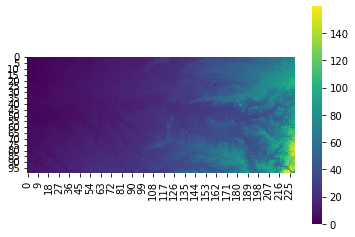

In [14]:
# np.savetxt(gwfm_dir+'\DIS_data\dem_44_7_200m_nearest.tsv', dem_data, delimiter = '\t')

# Based on Maribeth's grid aligned with Alisha's TPROGS model
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_nearest.tsv', delimiter = '\t')
dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_44_7_200m_linear_missing_right_corner.tsv', delimiter = '\t')

# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_44_7_200m_nearest.tsv', delimiter = '\t')

import seaborn as sns
sns.heatmap(dem_data, cmap = 'viridis', vmin = 0,square=True)

# Capture cross section of deeper geology

In [13]:
# Pre-cretaceous metamorphic rocks - (variable thickness 200-500 ft thick)
# Ione formation (200 ft thick)
# Valley Springs formation (300 ft thick)
# Mehrten Formation (100 ft thick to 300 ft thick) (1-2 deg dip)
# Laguna Formation (less than 100 ft to between 200-300 ft thick) (less than 1 deg dip)
# upper formation (informed by well logs) (100 ft)
# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell

## Need to adjust for change in model grid, based on Michigan Bar previously, maybe also look at effect of model domain angle vs cross section angle

In [14]:

# The stream gage at michigan bar is now 13 columns in from the boundary
# mehrtenbound

# Cross section E appears to have an angle of 0 compared to the model domain,

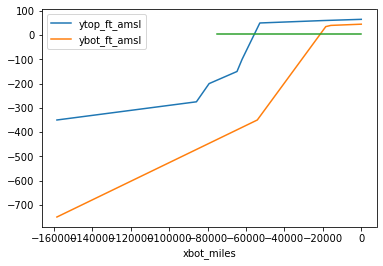

In [49]:
# # columns are xtop_miles, ytop_ft_amsl, xbot_miles, ytop_ft_amsl
# # XS upper bound should be at Michigan bar which is between Jackson road and Sacramento-Amador county line split
# # Mile 36 is approximately where Michigan bar aligns with the cross section
MB_XS_mile = 36
mehrtenbound = pd.read_csv(gwfm_dir+'/DIS_data/Mehrten_boundary_x_y.csv', parse_dates = False, 
                index_col = False, sep = ',', header = 'infer')
# Convert miles to feet and sets x value based on location of Michigan bar
# 0 is michigan bar and each major change in geologic dip is based on distance from Michigan Bar
mehrtenbound.xtop_miles = -5280*(MB_XS_mile - mehrtenbound.xtop_miles)
mehrtenbound.xbot_miles = -5280*(MB_XS_mile - mehrtenbound.xbot_miles)
# No flod boundary based on the original coordinates of the bottom of the Mehrten formation
mehrtenbound.noflow_x_miles = -5280*(MB_XS_mile - mehrtenbound.noflow_x_miles)

# East of mile 32 the entire vertical cross section, including up to the near entire surface
# is composed of old geologic formations that are not water bearing
volcanic_bound = (MB_XS_mile - 32)*-5280
# noflow_ind = int((1-(volcanic_bound/sumx))*ncol)

# Plot the x and y values
fig, ax = plt.subplots(1, 1)
mehrtenbound.plot(x = 'xtop_miles', y = 'ytop_ft_amsl', ax = ax)
mehrtenbound.plot(x = 'xbot_miles', y = 'ybot_ft_amsl', ax = ax)
plt.plot(-100*3.28*np.arange(0,len(dis.top[40,:])), np.flip(3.28*dis.top[40,:]))
# print(mehrtenbound)

In [50]:

def xy_to_botm(xbound_ft, ybound_ft, nspace,ntransversespace):
    laybotm = np.zeros((ntransversespace, nspace))
    # Nspace will be either nrow or ncol depending model direction
    # ntransversespace is the opposite of nspace (ie nrow if nspace is ncol)
    # Calculate the distance between each major change in dip
    dx = np.diff(xbound_ft)
    # Scale by the total distance across the coordinates to get percentages
    sumx = np.sum(dx)
    dx /= sumx
    # Multiply the number of columns by the percent of columns in each section of constant dip
    dx *= nspace
    # Round the number of columns to allow proper use for indexing
    nx = np.round(dx).astype(int)
    # Fix any discrepancy in number of columns due to issues with rouding the percentages of columns
    # Add a column to the last set of columns because there is already uncertainty at the deeper end
    while(np.sum(nx)-nspace !=0):
        if np.sum(nx)-nspace <0:
            nx[-1] += 1
        elif np.sum(nx)-nspace >0:
            nx[-1] -= 1
    sum(nx)

    # Now split the coordinates into downsized coordinates in between each major change in dip
    k = 0
    for i in np.arange(0,len(nx)):
        for j in np.arange(0,ntransversespace):
            laybotm[j, k:k+nx[i]] = np.arange(ybound_ft[i],ybound_ft[i+1], -(ybound_ft[i]-ybound_ft[i+1])/nx[i])
        k += nx[i]
    return(laybotm)

In [51]:
# X (east -west) and y (up-down vertical) of major dip changes for Mehrten Formation top boundary

mehrten_top = xy_to_botm(mehrtenbound.xtop_miles,mehrtenbound.ytop_ft_amsl, ncol, nrow)
# X (east -west) and y (up-down vertical) of major dip changes for Mehrten Formation bottom boundary
# drop na is because there are less values to mark changes in the bottom than top boundary
mehrten_bottom = xy_to_botm(mehrtenbound.xbot_miles.dropna(),mehrtenbound.ybot_ft_amsl.dropna(), ncol, nrow)

# Original x,y data for Mehrten bottom boundary to represent the noflow bounds
no_flow_bound = xy_to_botm(mehrtenbound.noflow_x_miles.dropna(), mehrtenbound.noflow_y_ft_amsl.dropna(),ncol,nrow)

In [52]:
botm = np.zeros((nlay, nrow, ncol))
# Convert units from ft to meters and flip to match direction
botm[-2,:,:] = np.flip(mehrten_top/3.28)
botm[-1,:,:] = np.flip(mehrten_bottom/3.28)
no_flow_bound = np.flip(no_flow_bound/3.28)
dis.botm = botm
# dis.plot()

## Adjustment to bottom boundary to ensure sufficient top layer thickness for the TPROGS model
Although the bottom boundaries are being artifically lowered to allow for sufficient layer thickness, this will be corrected when ibound is implemented based on where the actual bottom boundary is and where there is high elevations based on likelihood to be volcanics geology.  
TPROGs extends from -80 to 80. The lowest point in the DEM is -5m, we should drop more than 1m below this to ensure adequate thickness for calculations. This leaves -6 m to -80 for TPROGs with standard upscaling, so 148 layers

In [53]:
# The TPROGS model is 100m thick with some of it above the land surface
# to be safe, there should be at least 50 meters below ground surface to the bottom boundary

# Create 4 layers representing the upscaled "unsaturated" zone 
# ensures there is at least 1 m for each upscaled layer and rounded to create a clean boundary with the TPROGS data
leveling_layer_bottom = np.round(np.min(dem_data) - num_leveling_layers*1) - 1
# minimum thickness between top layer and Laguna?
leveling_layer_thickness = -10 # (dem_data - leveling_layer_bottom)/num_leveling_layers
botm[num_leveling_layers-1,:,:] = leveling_layer_bottom
for i in np.arange(num_leveling_layers-1,0,-1):
    botm[i-1,:,:] = botm[i,:,:] + leveling_layer_thickness
    
# Create TPROGS layers from top down
for i in np.arange(num_leveling_layers, num_leveling_layers + num_tprogs):
    botm[i,:,:] = botm[i-1,:,:] -tprog_thick
    
# Thickness to give to bottom layers below the TPROGS layers just to provide adequate spacing,
# this will be corrected by changing the geology in the layers above to account for what is actually in
# the Mehrten and what is in the Laguna formations, thickness of 5 also prevents any messy overlap
thickness_to_skip =10
# # Find where top boundary of Mehrten Formation rises within 10 meters of the top layer (10m for sufficient layer thickness)
bot3ind = np.min(np.where(botm[-2,:,:]>botm[-3,:,:]- thickness_to_skip)[1])

# # Where the top boundary of Mehrten was within 10 meters of the top layer 
# # set it equal to top layer elevation minus 10 for sufficient layer thickness
botm[-2,:,bot3ind:] = botm[-3,0,bot3ind]- thickness_to_skip
# # Repeat steps above for bottom of Mehrten formation with the top of the Mehrten formation
bot3ind = np.min(np.where(botm[-1,0,:]>botm[-2,0,:]- thickness_to_skip))
botm[-1,:,bot3ind:] = botm[-2,0,bot3ind]-thickness_to_skip

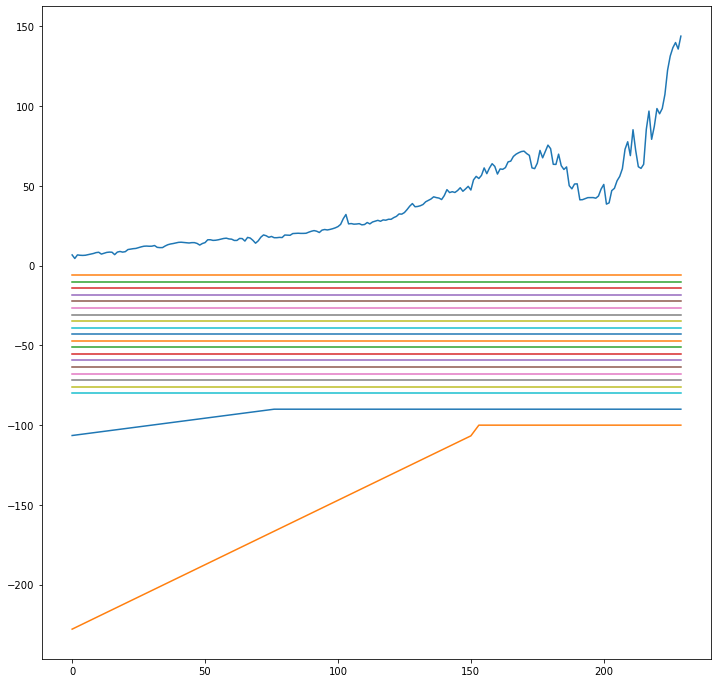

In [54]:
# when you apply the 1/200 aspect the dips in the cell seem a lot less severe, so may just leave the layering as is
# for now with 4 layers representing the unsaturated zone
fig,ax = plt.subplots(figsize = (12,12))
# ax.set_aspect(aspect = 1/10)
plotrow = 80
plt.plot(dem_data[plotrow,:])

for i in np.arange(0,nlay):
    plt.plot(botm[i,plotrow,:])

In [55]:
# Set the elevation of the top layer based on the DEM
m.dis.top = dem_data
# Bottom of model based on geology
m.dis.botm = botm
chk = dis.check()
chk.summary_array


DIS PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    zero or negative thickness
    thin cells (less than checker threshold of 1.0)
    nan values in top array
    nan values in bottom array



rec.array([],
          dtype=[('type', 'O'), ('package', 'O'), ('k', '<i4'), ('i', '<i4'), ('j', '<i4'), ('value', '<f8'), ('desc', 'O')])

## Complex ibound

### Define no flow cells based on elevation, informed by DWR cross sections and geologic maps of volcanic geology fingers leaving the mountains
In general, the location of Michigan Bar is near the boundary where there is total volcanics to majority alluvium. However there is a major finger North and South of the Cosumnes River of andesititc conglomerate, sandstone, breccia

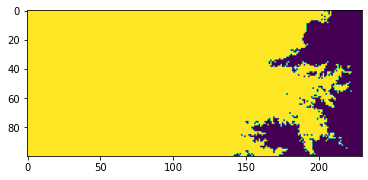

In [56]:
# Simplified ibound, only no flow cell if it is below the bottom of the Mehrten Formation
# Specify no flow boundary based on rough approx of geology (upper basin volcanics)
ibound = np.ones([nlay, nrow,ncol])


cutoff_elev = 56
ibound = ibound*(dem_data<cutoff_elev)

plt.imshow(ibound[0,:,:])

### Create a line bounding the noflow region to set the specified head boundary

In [57]:
import pprint
from rasterio.features import shapes, rasterize

# The function shapes from rasterio requires uint8 format
ibound_line = ibound.astype(rasterio.uint8)
out = shapes(ibound_line,connectivity = 8)
alldata = list(out)

# maxl = 0
maxl = np.zeros(len(alldata))
for i in np.arange(0,len(alldata)):
    maxl[i] = len(alldata[i][0].get('coordinates')[0])
#     if len(alldata[i][0].get('coordinates')[0])>maxl:
#         maxl = len(alldata[i][0].get('coordinates')[0])
#         ind = i
# select the two longest linestring indexes (1st will be chunk down of divide (lower elevation) 2nd will chunk above (high elev))
maxl1, maxl2 = np.where(maxl>np.mean(maxl))[0]
print(maxl[maxl>np.mean(maxl)])

[647. 607.]


In [58]:
temp = alldata[maxl2][0].get('coordinates')[0]
tl = LineString(temp)
tl

In [59]:
from shapely.ops import LineString, linemerge, polygonize, unary_union
tl = LineString(temp)

# Get the constant head or general head boundary after the no flow cells
linerast = rasterio.features.rasterize([tl], out_shape = np.array((nrow,ncol)))
# remove far east bound line
linerast[:,ncol-1] = 0
fix_bound = np.min(np.argwhere(linerast[0,:]==1))
linerast[0,:] = 0
linerast[0,fix_bound]
np.shape(linerast)

# ibound[0,linerast==1] = -1

(100, 230)

In [60]:
from shapely.ops import LineString, linemerge, polygonize, unary_union
tl = LineString(temp)
tu = unary_union(tl)
poly = list(polygonize(tu))
# Set the polygon/raster for the top layer, no buffer needed
poly0 = poly[0].buffer(distance = 0)
polyrast0 = rasterio.features.rasterize([poly0], out_shape = np.array((nrow,ncol)))
# Set the polygon/raster for the top layer, slight buffer needed to expand geologic formation outward with depth as 
# naturally occurs
poly1 = poly[0].buffer(distance = 13)
polyrast1 = rasterio.features.rasterize([poly1], out_shape = np.array((nrow,ncol)))
# Set the polygon/raster for the bottom layer, largest buffer needed
poly2 = poly[0].buffer(distance = 17)
polyrast2 = rasterio.features.rasterize([poly2], out_shape = np.array((nrow,ncol)))

ibound = np.ones([nlay, nrow,ncol])
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
# it is better to define the top layer with a simple dem>elevation check than the rasterize functins that isn't perfect
# ibound[0,polyrast0==1] = 0
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
ibound[-2,polyrast1==1] = 0
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
ibound[-1,polyrast2==1] = 0

# The bottom boundary has a dip of 1-2 degrees which is essentially a slope of 0.015 based on given cross section data
# The layer thickness for TPROGS
laythk = tprog_thick
# It appeared shapely buffer is on the scale of kilometers
run = (laythk/0.015)/1000
run_const = run
for i in np.arange(1,nlay-2):
    # error saying poly[i] is not subscriptable
    polyi = poly[0].buffer(distance = run)
    polyrast = rasterio.features.rasterize([polyi], out_shape = np.array((nrow,ncol)))
    # Need to decide whether all layers or just the top layer are affected by ibound from elevation
    ibound[i,polyrast==1] = 0
    run += run_const

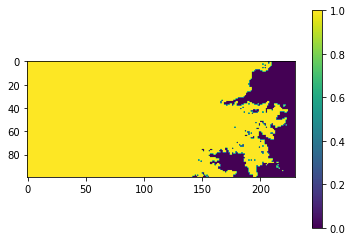

In [61]:
# wherever the constant head/specified head bound is the cells need to be active
ibound[0,dem_data>cutoff_elev] = 0
ibound[0,linerast==1] = 1
plt.imshow(ibound[0,:,:])
plt.colorbar()

In [62]:
# copy the ibound array to alter the geology array to set these cells as low permeability formations
# either marine or volcanic based
deep_geology = np.invert(ibound[:,:,:].astype(bool))

# reset ibound to all active cells to reduce non-linearity
# still need to take account of no flow cells for lake package
ibound = np.ones([nlay, nrow,ncol])

In [29]:
# np.savetxt(gwfm_dir+'/BAS6/deep_geology_'+str(nlay)'layer.tsv',np.reshape(deep_geology, (nlay*nrow,ncol)), delimiter ='\t')
# deep_geology = np.loadtxt(m.model_ws+'/input_data/deep_geology.tsv', delimiter ='\t')
# deep_geology = np.reshape(deep_geology, (nlay,nrow,ncol))

### Remove no flow cells in the first layer where there are stream cells

In [30]:
# where the specified head boundary is the cells must be active
# ibound[0,chd_locs[0], chd_locs[1]] = -1

In [586]:
strt = np.ones((nlay, nrow, ncol), dtype = np.float32)
# The model should start in hydraulic connection
strt[:,:,:] = m.dis.top[:,:] #maybe the mean of starting heads i causing issues?

In [587]:
# Basic package, BAS

# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell
# strt is array of starting heads
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt)

In [590]:
bas.check()
# bas.write_file()


BAS6 PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    isolated cells in ibound array
    Not a number



## Northwest and Southeast GHB boundaries based on historical WSEL

In [68]:
# raster cropping will be done in outside script so the only part read in will be the final array
ghb_dir = gwfm_dir+'/GHB_data'

In [196]:
strtyear = pd.to_datetime(strt_date).year
endyear = pd.to_datetime(end_date).year+1
kriged_fall = np.zeros((int(endyear-strtyear),nrow,ncol))
kriged_spring = np.zeros((int(endyear-strtyear),nrow,ncol))

kriged_NW = np.zeros((int(endyear-strtyear)*2,ncol))
kriged_SE = np.zeros((int(endyear-strtyear)*2,ncol))
# keep track of which place in array matches to year
year_to_int = np.zeros((endyear-strtyear,2))

t=0
for year in np.arange(strtyear,endyear):
    
    # load and place spring kriged data in np array, load spring first
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/spring'+str(year)+'_kriged_WSEL.tsv')[0]
    df_grid = np.loadtxt(filename)
    kriged_spring[t,:,:] = df_grid
    
    # load and place fall kriged data in np array
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/fall'+str(year)+'_kriged_WSEL.tsv')[0]
    df_grid = np.loadtxt(filename)
    kriged_fall[t,:,:] = df_grid

    
    # save NW  dataframe
#     kriged_NW[t] = kriged_spring[t,0,:]
#     kriged_NW[2*t] = kriged_fall[t,0,:]
#     # save SE data frame
#     kriged_SE[t] = kriged_spring[t,nrow-1,:]
#     kriged_SE[2*t] = kriged_fall[t,nrow-1,:]
    
    year_to_int[t,0] = t
    year_to_int[t,1] = year
    t+=1
    

<AxesSubplot:>

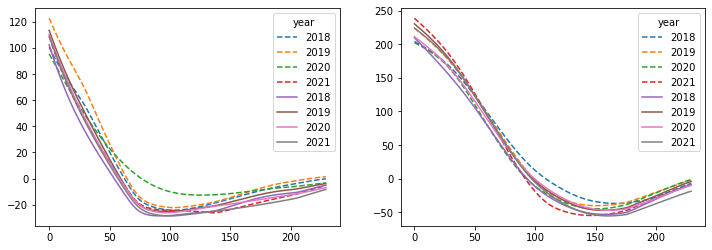

In [221]:
## NW is row 0, SE is last row
kriged_NW = np.vstack((kriged_spring[:,0,:],kriged_fall[:,0,:]))
kriged_SE = np.vstack((kriged_spring[:,nrow-1,:],kriged_fall[:,nrow-1,:] ))
fig,ax=plt.subplots(1,2, figsize=(12,4))
pd.DataFrame(np.rot90(kriged_NW),columns=sy_ind).loc[:,'spring'].plot(ax=ax[0],linestyle='--')
pd.DataFrame(np.rot90(kriged_NW),columns=sy_ind).loc[:,'fall'].plot(ax=ax[0])

pd.DataFrame(np.rot90(kriged_SE),columns=sy_ind).loc[:,'spring'].plot(ax=ax[1],linestyle='--')
pd.DataFrame(np.rot90(kriged_SE),columns=sy_ind).loc[:,'fall'].plot(ax=ax[1])

In [194]:
# fig,ax=plt.subplots()
# for s in ['spring']:
#     for y in np.arange(2013,2018):
#         fn = ghb_dir+'/final_WSEL_arrays/'+s+str(y)+'_kriged_WSEL.tsv'
#         hd_arr = np.loadtxt(fn)
#         ax.plot(hd_arr[0,:],'--',label=y)
# for s in ['fall']:
#     for y in np.arange(2013,2018):
#         fn = ghb_dir+'/final_WSEL_arrays/'+s+str(y)+'_kriged_WSEL.tsv'
#         hd_arr = np.loadtxt(fn)
#         ax.plot(hd_arr[0,:],'-',label=y)
# plt.legend()
# # fall 2019 is too high, spring 2020 is too low

In [222]:
y_num=0

nwhead_fall = kriged_fall[:,0,:]
sehead_fall = kriged_fall[:,-1,:]


# Set kriged water table elevations that are above land surface to land surface
nwhead_fall = np.where(nwhead_fall>dem_data[0,:], dem_data[0,:], nwhead_fall)
sehead_fall = np.where(sehead_fall>dem_data[-1,:], dem_data[-1,:], sehead_fall)

kriged_NW = np.where(kriged_NW>dem_data[0,:], dem_data[0,:], kriged_NW)
kriged_SE = np.where(kriged_SE>dem_data[-1,:], dem_data[-1,:], kriged_SE)

# calculate the average depth to water table for the spring and from 2013-2018 for the northwest and southeast boundary
avg_nw = np.nanmean(kriged_NW,axis=0)
avg_se = np.nanmean(kriged_SE,axis=0)

In [223]:
# steady state GHB layering
nw_lay = np.zeros(ncol)
se_lay = np.zeros(ncol)
for k in np.arange(0,nlay-1):
        # pull out elevation of layer bottom
        lay_elevnw = botm[k, 0, :]
        lay_elevse = botm[k, -1, :]
        for j in np.arange(0,ncol):
            if lay_elevnw[j] > avg_nw[j]:
                nw_lay[j] = k+1
            if lay_elevse[j] > avg_se[j]:
                se_lay[j] = k+1
# correct from float to integer for cell referencing
nw_lay = nw_lay.astype(int)
se_lay = se_lay.astype(int)

In [224]:
pd.DataFrame(np.rot90(kriged_NW))
sy_ind = np.repeat(['spring','fall'],(endyear-strtyear)),np.tile(np.arange(strtyear,endyear),2)
sy_ind = pd.MultiIndex.from_arrays(sy_ind, names=['season','year'])
sy_ind

MultiIndex([('spring', 2018),
            ('spring', 2019),
            ('spring', 2020),
            ('spring', 2021),
            (  'fall', 2018),
            (  'fall', 2019),
            (  'fall', 2020),
            (  'fall', 2021)],
           names=['season', 'year'])

## Read in TPROGS data

In [37]:
# "C:\Users\ajcalder\Box\research_cosumnes\Large_TPROGS_run\TPROGS_realizations\tsim_Cosumnes_Full_Model.asc1"
# create tprogs directory reference to 100 large tprogs runs ascii files
# tprogs_dir = os.path.dirname(gwfm_dir)+'/Large_TPROGS_run/Archive/TPROGS_realizations/'
# # get all file names
# tprogs_files = glob.glob(tprogs_dir+'*')


In [225]:
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')


In [226]:
gel_dir = gwfm_dir+'/UPW_data'
if 'ZonePropertiesInitial.csv' in os.listdir(model_ws):
    params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv',index_col='Zone')
else:
    params = pd.read_csv(gel_dir+'/ZonePropertiesInitial.csv',index_col='Zone')
    params.to_csv(model_ws+'/ZonePropertiesInitial.csv')
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400    

In [227]:
def tprogs_cut_elev(tprogs_line, dem_data, **kwargs):
    rows = kwargs.get('rows', np.where(np.ones(dem_data.shape)==1)[0])
    cols = kwargs.get('cols', np.where(np.ones(dem_data.shape)==1)[1])
    tprogs_arr = np.reshape(tprogs_line, (320, 100,230))
    tprogs_c = np.reshape(tprogs_arr[:, rows,cols],
                             (tprogs_arr.shape[0],dem_data.shape[0],dem_data.shape[1]))
    tprogs_elev = np.copy(tprogs_c)
    # the bottom layer of the tprogs model is at -50 m amsl and the top layer is 50 m amsl
    t = 0
    for k in np.arange(-80,80,0.5):
        tprogs_elev[t,dem_data<k]= np.NaN
        t+=1
    masked_tprogs = ma.masked_invalid(tprogs_elev)
    return(masked_tprogs)

In [228]:
import numpy.ma as ma
def tprogs_cut_saturated(tprogs,kriged):
    tprogs_unsat = np.copy(tprogs)
    # the bottom layer of the tprogs model is at -80 m amsl and the top layer is 80 m amsl
    # set any tprogs cells below the average fall water table depth as np.nan
    t = 0
    for k in np.arange(-80,80,0.5):
        tprogs_unsat[t,kriged>k]= np.NaN
        t+=1
    masked_tprogs = ma.masked_invalid(tprogs_unsat)
    return(masked_tprogs)

In [466]:
def int_to_param(tprogs):
    tprogs[tprogs<0] *= -1
    tprogs = tprogs.astype(float)
    # flip tprogs model along z axis to match modflow definition of 0 as top (TPROGS says 0 is bottom)
    tprogs = np.flip(tprogs,axis=0)
    tprogs_K = ma.copy(tprogs)
    tprogs_Sy = ma.copy(tprogs)
    tprogs_Ss = ma.copy(tprogs)
    # hydraulic parameters from fleckenstein 2006
    # I-IV gravel, sand, muddy sand, mud
    # K in m/s, Sy, Ss
    for n in np.arange(1,5):
        tprogs_K[tprogs==n]= params.loc[n,'K_m_d']
    for n in np.arange(1,5):
        tprogs_Sy[tprogs==n]= params.loc[n,'Sy']
    for n in np.arange(1,5):
        tprogs_Ss[tprogs==n]= params.loc[n,'Ss']
            
    return(tprogs_K,tprogs_Sy,tprogs_Ss)


In [467]:
# check one or zero based but min:1, 90:mean, max:34
t=0
tprogs_line = np.loadtxt(tprogs_files[t])
masked_tprogs=tprogs_cut_elev(tprogs_line, dem_data)
K, Sy, Ss= int_to_param(masked_tprogs)


In [231]:
# take the mean water surface elevations for fall and spring
kriged_fall_avg = np.nanmean(kriged_fall,axis=0)
kriged_spring_avg = np.nanmean(kriged_spring,axis=0)
# take average between fall and spring water surface elevations
kriged_fall_spring_avg = (kriged_fall_avg+kriged_spring_avg)/2

In [469]:
from scipy.stats import hmean
unsat_hk = np.mean(tprogs_cut_saturated(K,kriged_fall_spring_avg),axis=0)
unsat_vka = hmean(tprogs_cut_saturated(K,kriged_fall_spring_avg))
unsat_sy = np.mean(tprogs_cut_saturated(Sy,kriged_fall_spring_avg),axis=0)
unsat_ss = np.mean(tprogs_cut_saturated(Ss,kriged_fall_spring_avg),axis=0)

# set any zero values to the average of the domain, should be added to the function above
# arithmetic mean is used because we are filling data and not calculating vertical averages
unsat_hk[unsat_hk.data==0] = np.mean(unsat_hk)
unsat_vka[unsat_vka.data==0] = np.mean(unsat_vka)
unsat_sy[unsat_sy.data==0] = np.mean(unsat_sy)
unsat_ss[unsat_ss.data==0] = np.mean(unsat_ss)

In [46]:
# the first layer starts at -10 m which corresponds to 20 layers below 0
# 0m AMSL is 160 layers above the bottom of tprogs which ends up giving 160-20 is layer 140 or 139 for 0 based

## LPF/UPW package

In [486]:
def elev_to_tprogs_layers(elev):
    # function to get the tprogs layers based on the given elevation
    # layer 0 is 80 meters, layer 1 is 79.5 meters, layer -1 is -80 meters
    elev_05 = np.round((elev) * 2) / 2 # dem rounded to the nearest 0.5
    elev_05[elev_05 >= 80] = 80# any elevation above 80 m is set to 80
    elev_indices = 160 - elev_05*2 # subtract the calculated row from 160 to get to 0 at 160 and 320 and -160
    return(elev_indices.astype(int))
    
def get_tprogs_for_elev(tprogs_arr, top_elev, bot_elev, **kwargs):
    # function to get tprogs data for given elevation band
    rows = kwargs.get('rows', np.where(np.ones(top_elev.shape)==1)[0])
    cols = kwargs.get('cols', np.where(np.ones(top_elev.shape)==1)[1])
    top_indices = elev_to_tprogs_layers(top_elev)
    bot_indices = elev_to_tprogs_layers(bot_elev)
    # find tprogs layer for desired rows and columns
    top_indices = top_indices[rows, cols].astype(int)
    bot_indices = bot_indices[rows, cols].astype(int)
    # the first row of the array will be the top layer and will progress downward until the max bottom is reached
    # with NaNs for rows,cols where there are less layers indexed than the max
    tprogs_subset = np.full(shape = (np.max(bot_indices - top_indices).astype(int), len(rows)),
                       fill_value = np.nan, dtype = float)
    max_layers = np.max(bot_indices - top_indices)
    for k in np.arange(0,max_layers):
        layexist = (bot_indices-top_indices) > k # pick where data should be referenced
        tprogs_subset[k, layexist] = tprogs_arr[top_indices[layexist]+k, rows[layexist], cols[layexist]]
    # return grabbed data in array format if entire domain was used
    if len(rows) == top_elev.shape[0]*top_elev.shape[1]:
        tprogs_subset = np.reshape(tprogs_subset, (max_layers, top_elev.shape[0], top_elev.shape[1]))
    # mask na values so they don't cause issues with gmean or hmean
    tprogs_subset = ma.masked_array(tprogs_subset, mask = np.isnan(tprogs_subset))
    return(tprogs_subset)

In [491]:
hk = np.zeros(botm.shape)
vka = np.zeros(botm.shape)
sy = np.zeros(botm.shape)
ss = np.zeros(botm.shape)

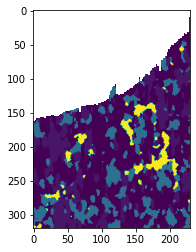

In [492]:
# plt.imshow(K[0,:,:])
# plt.imshow(K[-1,:,:])
plt.imshow(K[:,0,:])

In [493]:
Kx_upscaled = np.zeros((num_tprogs,nrow,ncol))
Kz_upscaled = np.zeros((num_tprogs,nrow,ncol))
Sy_upscaled = np.zeros((num_tprogs,nrow,ncol))
Ss_upscaled = np.zeros((num_tprogs,nrow,ncol))

for k in np.arange(1,num_tprogs+1):
    # calculate upscale from bottom up
    Kx_upscaled[-k,:,:] = np.nanmean(K[(-k*upscale):(-k*upscale-upscale):-1,:,:],axis=0)
    Kz_upscaled[-k,:,:] = hmean(K[(-k*upscale):(-k*upscale-upscale):-1,:,:],axis=0)
    Sy_upscaled[-k,:,:] = np.nanmean(Sy[(-k*upscale):(-k*upscale-upscale):-1,:,:],axis=0)
    Ss_upscaled[-k,:,:] = np.nanmean(Ss[(-k*upscale):(-k*upscale-upscale):-1,:,:],axis=0)

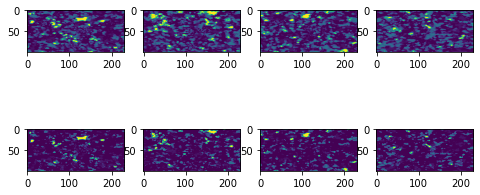

In [494]:
fig,ax=plt.subplots(2,4,figsize=(8,4))
for n in np.arange(0,4):
    ax[0,n].imshow(Kx_upscaled[n*4,:,:])
    ax[1,n].imshow(Kz_upscaled[n*4,:,:])


In [495]:
# # take of 2 for the bottom layers and 1 for the unsat zone layer up top
# # for tprogs arrays 0 is the bottom of the model, so flipping on z will fix
# hk[1:-2,:,:] = np.flip(K[-hk.shape[0]+1:-2,:,:],axis=0)
# sy[1:-2,:,:] = np.flip(Sy[-sy.shape[0]+1:-2,:,:],axis=0)
# ss[1:-2,:,:] = np.flip(Ss[-ss.shape[0]+1:-2,:,:],axis=0)
hk[1:-2,:,:] = Kx_upscaled
vka[1:-2,:,:] = Kz_upscaled
sy[1:-2,:,:] = Sy_upscaled
ss[1:-2,:,:] = Ss_upscaled

The LPF package should use the means for the complete TPROGs layers available for the first layer

In [496]:
lay1_HK = np.mean(get_tprogs_for_elev(K, m.dis.top.array, m.dis.botm.array[0,:,:]),axis=0)
lay1_VK = hmean(get_tprogs_for_elev(K, m.dis.top.array, m.dis.botm.array[0,:,:]),axis=0)
lay1_Sy = np.mean(get_tprogs_for_elev(Sy, m.dis.top.array, m.dis.botm.array[0,:,:]),axis=0)
lay1_Ss = np.mean(get_tprogs_for_elev(Ss, m.dis.top.array, m.dis.botm.array[0,:,:]),axis=0)



In [497]:
# set parameters based on upscaled unsaturated zone
hk[0,:,:] = lay1_HK
vka[0,:,:] = lay1_VK
sy[0,:,:] = lay1_Sy
ss[0,:,:] = lay1_Ss

The tuff breccia is very dense, hard and low water yielding. It is supposedly responsible for the many "haystack" hills in the eastern part of the county

DWR report has a few final well pumping rates, drawdowns and specific capacities but limited.

Fleckenstein et al. 2006 found the Mehrten had
Kh = 1 to 1.8 x10^-5 m/s
Kv = 1 to 1.8 x10^-7 m/s
Sy = 0.15 to 0.2
Ss = 1e-4 to 1e-3 m^-1

In [498]:
# set values for second to bottom layer, Laguna formation
hk[-2,:,:] = params.loc[5,'K_m_d']
vka[-2,:,:] = params.loc[5,'K_m_d']/100 # assume 1/100 for Kx to Kz
sy[-2,:,:] = params.loc[5,'Sy']
ss[-2,:,:] = params.loc[5,'Ss']

# the deep_geology array shows where the mehrten formation comes out of the surface
hk[deep_geology[:,:,:].astype(bool)] = params.loc[6,'K_m_d']
vka[deep_geology[:,:,:].astype(bool)] = params.loc[6,'K_m_d']/100 # assume 1/100 for Kx to Kz
sy[deep_geology[:,:,:].astype(bool)] = params.loc[6,'Sy']
ss[deep_geology[:,:,:].astype(bool)] = params.loc[6,'Ss']

# set values for bottom layer, Mehrten formation
hk[-1,:,:] = params.loc[6,'K_m_d']
vka[-1,:,:] = params.loc[6,'K_m_d']/100 # assume 1/100 for Kx to Kz
sy[-1,:,:] = params.loc[6,'Sy']
ss[-1,:,:] = params.loc[6,'Ss']

In [499]:
# layvka 0 means vka is vert K, non zero means its the anisotropy ratio between horiz and vert
layvka = 0

# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
# 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# laytyp = np.ones(nlay)  
laytyp = np.zeros(nlay)
# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
laywet = np.zeros(len(laytyp))
laywet[laytyp==1] = 1
#ipakcb = 55 means cell-by-cell budget is saved because it is non zero (default is 53)

# until upscaling is begun then vertical and horiz K are the same for TPROGS
# gel = flopy.modflow.ModflowUpw(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, ss=ss,
#             laytyp=laytyp, ipakcb=55)

gel = flopy.modflow.ModflowLpf(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, ss=ss,
                               laytyp=laytyp, laywet = laywet, ipakcb=55)

In [57]:
# gel.write_file()

In [58]:
# m.remove_package('UPW')

In [59]:
# option to make switching between packages easier
# 'LPF' in m.get_package_list()

## Review geologic parameters

HK of Mehrten and Laguna:  [0.00864 0.864  ]
Layer 1 range:  [8.6400000e-03 8.6406480e+01 1.7280432e+02 2.5920216e+02 3.4560000e+02]
Layer 5 range:  [8.6400000e-03 8.6406480e+01 1.7280432e+02 2.5920216e+02 3.4560000e+02]


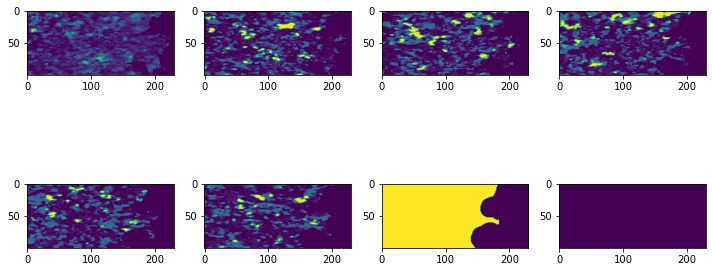

In [701]:

lays2plt = [0,1,4,8,14,18,19,20]
plt_cols = 4
fig,ax=plt.subplots(int(len(lays2plt)/plt_cols),plt_cols,figsize=(10,6))
for n,k in enumerate(lays2plt):
    im = ax[int(n / plt_cols), n % plt_cols].imshow(hk[k,:,:])
fig.tight_layout()
# plt.colorbar(mappable=im)
print('HK of Mehrten and Laguna: ',np.unique(hk[19,:,:]))
print('Layer 1 range: ', np.histogram(hk[0,:,:],4)[1])
print('Layer 5 range: ',np.histogram(hk[4,:,:],4)[1])

### Scaling factors for GHB, RIV, UZF/RCH and WEL package

In [350]:
gel_dir = gwfm_dir+'/UPW_data'
if 'GHB_UZF_WEL_scaling.csv' in os.listdir(model_ws):
    scaling_factors = pd.read_csv(model_ws+'/GHB_UZF_WEL_scaling.csv',delimiter = ',')
else:
    scaling_factors = pd.read_csv(gel_dir+'/GHB_UZF_WEL_scaling.csv',delimiter = ',')
    scaling_factors.to_csv(model_ws+'/GHB_UZF_WEL_scaling.csv')



## Import soil data for Lake Package, UZF Package, SFR Package hydraulic parameters

In [351]:
mb_name = gwfm_dir+"/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"

mb = gpd.read_file(mb_name)
mb = mb.to_crs('epsg:32610')

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [352]:
uzf_path = gwfm_dir+'\\UZF_data'
soil_path = uzf_path+'\\wss_gsmsoil_CA'
# # Read in the soil map spatial data
# soil_gpd = gpd.read_file(uzf_path+'\\wss_gsmsoil_CA\\spatial\\gsmsoilmu_a_ca.shp')
# soil_gpd = soil_gpd.to_crs('EPSG:32610')
# # soil_gpd.plot()

### Write grid_uzf to shapefile to avoid having to repeat analysis

In [353]:
# grid_uzf.to_file(uzf_path+'/final_grid_uzf/griduzf.shp')
# grid_uzf = gpd.read_file(uzf_path+'/final_grid_uzf/griduzf.shp')

In [64]:
# def fill_uzf(uzfvalues, grid_uzf):
#     # convert geopandas object to regular np array for soil data
#     temp = np.zeros((nrow,ncol))
#     temp[(grid_uzf.row.values-1).astype(int),(grid_uzf.column.values-1).astype(int)] = uzfvalues
#     return(temp)

In [354]:
soilKs_array = np.loadtxt(uzf_path+'/final_soilKs.tsv', delimiter = '\t')
soiln_array = np.loadtxt(uzf_path+'/final_soiln.tsv', delimiter = '\t')
soileps_array = np.loadtxt(uzf_path+'/final_soileps.tsv', delimiter = '\t')
soildepth_array = np.loadtxt(uzf_path+'/final_soildepth.tsv', delimiter = '\t')

# soilKs_array = fill_uzf(grid_uzf.Ksat_Rep, grid_uzf)
# soiln_array = fill_uzf(grid_uzf.Porosity_R, grid_uzf)
# soileps_array = fill_uzf(grid_uzf.EPS, grid_uzf)

# np.savetxt(uzf_path+'/final_soilKs.tsv', soilKs_array, delimiter = '\t')
# np.savetxt(uzf_path+'/final_soiln.tsv', soiln_array, delimiter = '\t')
# np.savetxt(uzf_path+'/final_soileps.tsv', soileps_array, delimiter = '\t')

# SFR

In [357]:
sfr_dir = gwfm_dir+'/SFR_data/'

In [67]:
# mb_name = gwfm_dir+"/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"
# # mb_name = gwfm_dir+"/GWModelDomain_UTM10N/GWModelDomain_Rec_UTM10N.shp"

# # Rivers and creeks in the larger area encompassing Cosumnes River in both South American and Cosumnes Subbasins
# rivers = gpd.read_file(gwfm_dir+"/SFR_data/Sac_valley_rivers/Sac_valley_rivers.shp")
# mb = gpd.read_file(mb_name)
# mb = mb.to_crs('epsg:32610')
# rivers = rivers.to_crs('EPSG:32610')
# rivers_clip = gpd.clip(rivers, mb)
# rivers_clip.plot()
# # rivers_clip.GNIS_Name.unique()

In [68]:
# print(rivers_clip.columns)
# # Split into individual streams/creeks
# cr_ind = rivers_clip[rivers_clip.GNIS_Name == 'Cosumnes River']
# dc_ind = rivers_clip[rivers_clip.GNIS_Name == 'Deer Creek']
# cc_ind = rivers_clip[rivers_clip.GNIS_Name ==  'Coyote Creek']
# # Pull out data for each river/creek
# cr = rivers_clip.loc[cr_ind.index,]
# dc = rivers_clip.loc[dc_ind.index,]
# cc = rivers_clip.loc[cc_ind.index,]


In [69]:
# import fiona
# from shapely.geometry import shape, mapping
# from shapely.ops import linemerge

# cr.geometry.values.crs = "epsg:32610"
# geom = linemerge(cr.geometry.values)
# # how often to interpolate a point
# dline = 10
# # # length of the LineString
# length = int(geom.length)
# point = np.zeros((int(length/dline)+1,3))
# for i, distance in enumerate(range(0, int(length), dline)):
#          point[i,:] = geom.interpolate(distance).coords[:][0]
# point = point[:,[0,1]]
# plt.plot(point[:,0],point[:,1])


In [70]:
# raster_name = gwfm_dir+'/DEM_data/USGS_ten_meter_dem/regional_10m.tif'

# # dem10 = rasterio.open(raster_name)

# pnts = pd.DataFrame()
# with rasterio.open(raster_name) as src:
#     pnts['z'] = [sample[0] for sample in src.sample(point)]
# pnts
# pnts['easting'] = point[:,0]
# pnts['northing'] = point[:,1]
# pnts = pnts[pnts.z > -1E4]



In [71]:
# plt.figure(figsize = (10,10))
# pnts.z.plot()
# pnts['slope'] = 0.002
# for i in np.arange(1,len(pnts)):
#     if pnts.z.values[i] >= pnts.z.values[i-1]:
#         # if strtop is greater than previous strtop use previous elevation minus the average slope
#         slope = ((np.max(pnts.z) - np.min(pnts.z))/geom.length)*dline
#         if pnts.index[i] < 800:
#             slope = 0.002
#         elif pnts.index[i] < 2700:
#             slope = 0.0003
#         elif pnts.index[i] < 3200:
#             slope = 0.001
#         else:
#             slope = 0.0003
#         pnts.z.values[i] = pnts.z.values[i-1] - slope*dline
#         pnts.slope.values[i] = slope
# pnts.z.plot()

In [72]:
#  pnts['Point_order'] = pnts.index

In [73]:
# pnts_gpd = gpd.GeoDataFrame(pnts, geometry = gpd.points_from_xy(pnts.easting, pnts.northing))
# pnts_gpd.crs = 'epsg:32610'

In [74]:
# plot_lines(m.modelgrid.grid_lines)
# Write model grid to shapefile of polygons
# m.modelgrid.write_shapefile('grid/grid.shp', epsg = '32610')
# grid_p = gpd.read_file('grid/grid.shp')

In [75]:
# # Samples the points every 10 meters to match with the 100 meter grid
# grid_sfr = gpd.sjoin(grid_p, pnts_gpd, how = "inner", op= "intersects")
# 

In [76]:
# # Set reach length for each reach based on the separation used to create the points from the line object
# # dline is 10 meters
# grid_sfr['length_m'] = dline

# # Dissolve the points again but using sum this time to get the total length of each reach
# temp = grid_sfr.dissolve(by = 'node', aggfunc = 'sum').length_m.values

# # Dissolves the points every 10 meters to the 200 meter spacing, using mean because the interested component is elevation
# grid_sfr = grid_sfr.dissolve(by = 'node', aggfunc = 'mean')
# grid_sfr.length_m = temp

In [77]:
# print('mean stream length in cell is ', grid_sfr.length_m.mean(), ' meters')
# grid_sfr.length_m.hist()


# length_threshold =100

# fig,ax=plt.subplots(figsize=(10,10))
# grid_sfr.loc[grid_sfr.length_m >length_threshold].plot(ax=ax)
# grid_sfr.loc[grid_sfr.length_m >length_threshold].shape

# print('even after setting cutoff at 100m there is still stream connection')

In [78]:
# remove reaches with a length less than 100m, short reaches with high conductance can lead to large errors
# in the SFR package and unneccessarily increase computation time
# grid_sfr = grid_sfr.loc[grid_sfr.length_m >length_threshold]

# reorder reaches, and relabel the reach numbering after removing very shroty reaches
# grid_sfr = grid_sfr.sort_values(by = 'Point_order')
# grid_sfr['reach'] = np.arange(1,len(grid_sfr)+1)

## Adjust Blodgett Dam scenario here

In [361]:
# scenario = 'dam'
# scenario = 'actual'
# scenario = 'new'
scenario = 'none'

In [362]:
# grid_sfr.to_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')


C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array

In [363]:
XS8pt = pd.read_csv(sfr_dir+'8pointXS.csv')
# XSlocs = gpd.read_file(sfr_dir+'8pointXS_locs/8pointXS_locs.shp')
# new shapefile with an extra point for blodgett dam as site 16.5
XSlocs = gpd.read_file(gwfm_dir+'/Blodgett_Dam/geospatial/8pointXS_locs/8pointXS_locs.shp')
XSlocs.crs = 32610

XSg  = gpd.sjoin(grid_sfr, XSlocs, how = "inner", op= "contains", lsuffix = 'sfr',rsuffix = 'xs')
# print(len(XSg))

# # Append the grid_breach location to the list of cross sections to split the segment
# XSg = XSg.append(grid_breach).sort_values('reach')
# # Copy the XS site name from the previous last site to the breach site to keep same XS
# XSg.Site.iloc[-1] = XSg.Site.iloc[-2]
# len(XSg), len(XS8pt.loc[0,:])/2

if scenario == 'none':
    # if no blodgett dam scenario then remove the extra cross section
    XSg = XSg.loc[(XSg.Site!=16.5)]
    XSg = XSg.loc[(XSg.Site!=16.2)]
#     XSg = XSg.loc[XSg.Site!=16.2]
elif scenario == 'actual':
    XSg_side = XSg.loc[XSg.Site==16.5]
    XSg_side.loc[:,'Site'] = 16.4
    XSg = XSg.append(XSg_side)
elif scenario == 'design':
    # may or may not want to remove the segment before
    XSg = XSg.loc[(XSg.Site!=16.2)]

# if the scneario is the restructured or designed dam then no change in the segments is necessary
# sort by site to make sure any XS added are properly included
XSg = XSg.sort_values('Site')
# print(len(XSg))


In [82]:
# if scenario =='actual':
#     pre_rch_num = XSg.loc[XSg.Site==16.2,'reach'].iloc[0]
#     add_rch = grid_sfr.loc[grid_sfr.reach== pre_rch_num].copy()
#     # for all reaches after added reach, need to add 1 to the reach number
#     grid_sfr.loc[grid_sfr.reach>pre_rch_num,'reach'] = grid_sfr.loc[grid_sfr.reach>pre_rch_num,'reach'] +1
#     # using the desired reach add 1 to just the duplicate
#     add_rch.reach +=1
#     # extra channel is 10m in length because it is there just to allow transfer of flow
#     grid_sfr.loc[grid_sfr.reach== pre_rch_num,'length_m'] = 10
#     add_rch.z = add_rch.z-10*add_rch.slope # adjust elevation of added reach to account for slope required
#     grid_sfr = grid_sfr.append(add_rch).sort_values('reach')
#     # adjust XSg to account for chnages to grid_sfr
#     XSg.loc[XSg.reach>pre_rch_num,'reach'] +=1
#     XSg.loc[XSg.Site==16.2,'reach']+=1 #add one to 16.2 because can't have two of the same reach
    
#     # need to duplicate the reach for the segment
#     add_rch_num = XSg.loc[XSg.Site==16.4,'reach'].iloc[0]
#     add_rch = grid_sfr.loc[grid_sfr.reach== add_rch_num].copy()
#     # for all reaches after added reach, need to add 1 to the reach number
#     grid_sfr.loc[grid_sfr.reach>add_rch_num,'reach'] = grid_sfr.loc[grid_sfr.reach>add_rch_num,'reach'] +1
#     # using the desired reach add 1 to just the duplicate
#     add_rch.reach +=1

#     # side channel is 70m in length from satellite
#     # length of reach after dam can be kept the same but could be reduced slightly to account for addition of flooding/lake
#     grid_sfr.loc[grid_sfr.reach== add_rch_num,'length_m'] = 70
#     add_rch.z = add_rch.z-70*add_rch.slope # adjust elevation of added reach to account for slope required
#     grid_sfr = grid_sfr.append(add_rch).sort_values('reach')
    
#     # adjust XSg to account for chnages to grid_sfr
#     XSg.loc[XSg.reach>add_rch_num,'reach'] +=1
#     XSg.loc[XSg.Site==16.5,'reach']+=1 #add one to 16.5 because can't have two of the same reach


In [364]:
XSg['iseg'] = np.arange(2,len(XSg)+2) # add the segment that corresponds to each cross section

In [365]:

# if scenario == 'dam':
#     # designed scenario flow through dam only
#     new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/02_designed_XS.csv', skiprows=1)
# elif scenario =='actual':
#     # current situation, flow around dam and after dam
#     new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/03_actual_XS.csv', skiprows=1)
# elif scenario =='new':
#     # depending scenario, use different input cross sections for 16.5
#     new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/01_New_wide_XS.csv')

# if there is a scneario then need to add the new XS
if scenario != 'none':
    XS8pt = pd.concat([XS8pt,new_xs],axis=1)

some of the XS are not lining up with grid_sfr so they aren't being connected. Need to fix this and also look at how many XS are really needed to capture the change in river morphology

### Read in 8 pt XS, revised by simplifying from Constantine 2001

In [366]:
# There is one reach for each cell that a river crosses
NSTRM = -len(grid_sfr)
# There should a be a stream segment if there are major changes
# in variables in Item 4 or Item 6
# 1st segment is for the usgs Michigan Bar rating curve, one for each XS, plus 2 for the floodplain diversion
NSS = 1 + len(XSg) 
# NSS = 2
# nparseg (int) number of stream-segment definition with all parameters, must be zero when nstrm is negative
NPARSEG = 0
CONST = 86400 # mannings constant for SI units, 1.0 for seconds, 86400 for days
# real value equal to the tolerance of stream depth used in
# computing leakage between each stream reach and active model cell
DLEAK = 0.0001 # unit in lengths, 0.0001 is sufficient for units of meters
IPAKCB = 55
# writes out stream depth, width, conductance, gradient when cell by cell
# budget is specified and istcb2 is the unit folder
ISTCB2 = 54
# isfropt = 1 is no unsat flow
# specifies whether unsat flow beneath stream or not, isfropt 2 has properties read for each reach, isfropt 3 also has UHC
# read for each reach, isfropt 4 has properties read for each segment (no UHC), 5 reads for each segment with UHC
ISFROPT = 1
# nstrail (int), number of trailing weave increments used to represent a trailing wave, used to represent a decrease 
# in the surface infiltration rate. Can be increased to improve mass balance, values between 10-20 work well with error 
# beneath streams ranging between 0.001 and 0.01 percent, default is 10 (only when isfropt >1)
NSTRAIL = 20
# isuzn (int) tells max number of vertical cells used to define the unsaturated zone beneath a stream reach (default is 1)
ISUZN = 1
#nsfrsets (int) is max number of different sets of trailing waves (used to allocate arrays), a value of 30 is sufficient for problems
# where stream depth varies often, value doesn't effect run time (default is 30)
NSFRSETS = 30
# IRTFLG (int) indicates whether transient streamflow routing is active, must be specified if NSTRM <0. If IRTFLG >0 then
# flow will be routed with the kinematic-wave equations, otherwise it should be 0 (only for MF2005), default is 1
IRTFLG = 1
# numtim (int) is number of sub time steps used to route streamflow. Streamflow time step = MF Time step / NUMTIM. 
# Default is 2, only when IRTFLG >0
NUMTIM = 4
# weight (float) is a weighting factor used to calculate change in channel storage 0.5 - 1 (default of 0.75) 
WEIGHT = 0.75
# flwtol (float), flow tolerance, a value of 0.00003 m3/s has been used successfully (default of 0.0001)
# 0.00003 m3/s = 2.592 m3/day
# a flow tolerance of 1 cfs is equal to 2446.57 m3/day
# if my units are in m3/day then flwtol should be in m3/day
FLWTOL = 3


sfr = flopy.modflow.ModflowSfr2(model = m, nstrm = NSTRM, nss = NSS, nparseg = NPARSEG, 
                           const = CONST, dleak = DLEAK, ipakcb = IPAKCB, istcb2 = ISTCB2, 
                          isfropt = ISFROPT, nstrail = NSTRAIL, isuzn = ISUZN, irtflg = IRTFLG, 
                          numtim = NUMTIM, weight = WEIGHT, flwtol = FLWTOL,
                                reachinput=True, transroute=True, tabfiles=True,
                                tabfiles_dict={1: {'numval': nper, 'inuit': 56}})

In [367]:
# Add option block at the top of the sfr input file for tabfiles
tab_option = flopy.utils.OptionBlock(options_line = ' reachinput transroute tabfiles 1 ' + str(nper), package = sfr, block = True)
sfr.options = tab_option
# sfr.options

In [368]:
# Modflow NWT additions to SFR package set up
# sfr.transroute = True
# sfr.reachinput = True
# sfr.tabfiles = True
# # numval is the number of values in the flow tab files, inuit is the corresponding unit file
# sfr.tabfiles_dict = {1: {'numval': nper, 'inuit': 56}}

In [369]:
xs_sfr = grid_sfr.set_index('reach')
# set all reaches to start as segment 1 which will be changed iteratively based on the number of cross-sections
xs_sfr['iseg'] = 1
# add a column reach_new that will be changed iteratively as the segment number is changed
xs_sfr['reach_new'] = xs_sfr.index
# xs_sfr

## Define reach data based on ISFROPT

In [370]:
## Given the reach number of each XS, the 718 reaches will be broken down into each segment
## create a new reach column based on XS reach number and 

# segcount = 2
for i in np.arange(0,len(XSg)):
    temp_reach = XSg.reach.values[i]
    rchnum = xs_sfr.index[-1] - temp_reach+1
    xs_sfr.reach_new.loc[temp_reach:] = np.linspace(1,rchnum, rchnum)
#     xs_sfr.iseg.loc[temp_reach:] = segcount
    xs_sfr.iseg.loc[temp_reach:] = XSg.iseg.values[i]
#     segcount +=1
    
# for simple 1 XS model
# temp_reach = XSg.reach
# rchnum = xs_sfr.index[-1] - temp_reach+1
# xs_sfr.reach_new.loc[temp_reach:] = np.linspace(1,rchnum, rchnum)
# xs_sfr.iseg.loc[temp_reach:] = segcount
# segcount +=1

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [371]:
xs_sfr.reach_new = xs_sfr.reach_new.astype(int)


In [372]:
# Determine which layer the streamcell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# otherwise it would be less than and zero (most should be in layer 0)
sfr_lay = np.zeros(len(grid_sfr))

for i in np.arange(0,nlay-1):
    # pull out elevation of layer bottom
    lay_elev = botm[i, (grid_sfr.row.values-1).astype(int), (grid_sfr.column.values-1).astype(int)]
    for j in np.arange(0,len(grid_sfr)):
        # want to compare if streambed is lower than the layer bottom
        # 1 will be subtracted from each z value to make sure it is lower than the model top in the upper reaches
        if lay_elev[j] < (grid_sfr.z.values-1)[j]:
            sfr_lay[j] = i -1
        


In [373]:
# KRCH, IRCH, JRCH, ISEG, IREACH, RCHLEN, STRTOP, SLOPE, STRTHICK, STRHC1, THTS, THTI, EPS, UHC

columns = ['KRCH', 'IRCH', 'JRCH', 'ISEG', 'IREACH', 'RCHLEN', 'STRTOP', 
               'SLOPE', 'STRTHICK', 'STRHC1', 'THTS', 'THTI', 'EPS', 'UHC']

sfr_rows = (grid_sfr.row.values-1).astype(int)
sfr_cols = (grid_sfr.column.values-1).astype(int)

sfr.reach_data.node = grid_sfr.index
sfr.reach_data.k = sfr_lay.astype(int)
sfr.reach_data.i = sfr_rows
sfr.reach_data.j = sfr_cols
sfr.reach_data.iseg = xs_sfr.iseg
sfr.reach_data.ireach = xs_sfr.reach_new
sfr.reach_data.rchlen = xs_sfr.length_m.values
sfr.reach_data.strtop = grid_sfr.z.values-1
sfr.reach_data.slope = grid_sfr.slope.values
 # a guess of 2 meters thick streambed was appropriate
sfr.reach_data.strthick = soildepth_array[sfr.reach_data.i, sfr.reach_data.j]

# UZF parameters
sfr.reach_data.thts = soiln_array[sfr.reach_data.i, sfr.reach_data.j]/100
sfr.reach_data.thti = sfr.reach_data.thts
sfr.reach_data.eps = soileps_array[sfr.reach_data.i, sfr.reach_data.j]
sfr.reach_data.uch = unsat_vka[sfr.reach_data.i, sfr.reach_data.j].data


In [374]:
grid_sfr['dist_m'] = grid_sfr.length_m.cumsum()
grid_sfr.dist_m -= grid_sfr.dist_m.iloc[0]

## Could try TPROGs alternative 

In [375]:
topbotm = np.zeros((m.dis.nlay+1,m.dis.nrow,m.dis.ncol))
topbotm[0,:,:] = m.dis.top.array
topbotm[1:,:,:] = m.dis.botm.array

In [376]:
def elev_to_tprogs_layers(elev):
    # function to get the tprogs layers based on the given elevation
    # layer 0 is 80 meters, layer 1 is 79.5 meters, layer -1 is -80 meters
    elev_05 = np.round((elev) * 2) / 2 # dem rounded to the nearest 0.5
    elev_05[elev_05 >= 80] = 80# any elevation above 80 m is set to 80
    elev_indices = 160 - elev_05*2 # subtract the calculated row from 160 to get to 0 at 160 and 320 and -160
    return(elev_indices.astype(int))
    
def get_tprogs_for_elev(tprogs_arr, top_elev, bot_elev, **kwargs):
    rows = kwargs.get('rows', np.where(np.ones(top_elev.shape)==1)[0])
    cols = kwargs.get('cols', np.where(np.ones(top_elev.shape)==1)[1])
    top_indices = elev_to_tprogs_layers(top_elev)
    bot_indices = elev_to_tprogs_layers(bot_elev)
    # find tprogs layer for desired rows and columns
    top_indices = top_indices[rows, cols].astype(int)
    bot_indices = bot_indices[rows, cols].astype(int)
    # the first row of the array will be the top layer and will progress downward until the max bottom is reached
    # with NaNs for rows,cols where there are less layers indexed than the max
    tprogs_subset = np.full(shape = (np.max(bot_indices - top_indices).astype(int), len(rows)),
                       fill_value = np.nan, dtype = float)
    max_layers = np.max(bot_indices - top_indices)
    for k in np.arange(0,max_layers):
        layexist = (bot_indices-top_indices) > k # pick where data should be referenced
        tprogs_subset[k, layexist] = K[top_indices[layexist]+k, rows[layexist], cols[layexist]]
    # return grabbed data in array format if entire domain was used
    if len(rows) == top_elev.shape[0]*top_elev.shape[1]:
        tprogs_subset = np.reshape(tprogs_subset, (max_layers, top_elev.shape[0], top_elev.shape[1]))
    return(tprogs_subset)

Text(0.5, 0, 'Reach')

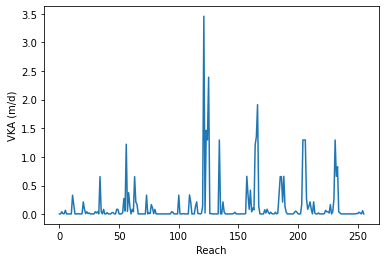

In [383]:
strbd_thick = 4
# get_tprogs_for_elev(K, m_c.dis.top.array, m_c.dis.top.array- np.linspace(1,4,m_c.dis.ncol), rows = sfr_rows, cols = sfr_cols)
strbd_tprogs = get_tprogs_for_elev(K, m.dis.top.array, m.dis.top.array- strbd_thick, rows = sfr_rows, cols = sfr_cols)
sfr_K = gmean(strbd_tprogs,axis=0)/100 # divide by 100 to ease convergence, but variability is still there
plt.plot(sfr_K)
plt.ylabel('VKA (m/d)')
plt.xlabel('Reach')
# temp fix to get convergence
# sfr_K = 0.01

In [97]:
# based on FIgure 7 Subtrate composition profile map of the Cosumnes RIver from COnstantine 2001

# subs_prof = pd.read_csv(sfr_dir+'substrate_river_profile.csv',skiprows=1)
# # the start of the Constantine profile is about 20km downstream from Michigann Bar which is the start of SFR
# subs_prof.end_river_km +=20
# subs_prof['river_m'] = subs_prof.end_river_km * 1000

# # range for tprogs is from 300 m/d for gravel to 0.5 m/d for mud
# # but anything above 0.1 causes too much interchange with the aquifer
# k_alluv = 0.1
# k_duri = 0.001
# k_alt = gmean([k_alluv,k_duri])
# subs_prof['ksat'] = 0
# subs_prof.loc[subs_prof.substrate=='alluvial','ksat'] = k_alluv
# subs_prof.loc[subs_prof.substrate=='duirpan','ksat'] = k_duri
# subs_prof.loc[subs_prof.substrate=='alternating','ksat'] = k_alt

# sfr_K = np.zeros(len(grid_sfr))
# subs_prof
# for i in np.arange(0,len(subs_prof)):
#     sfr_K[grid_sfr.dist_m<subs_prof.river_m[i]] = subs_prof.ksat[i]

In [384]:
# set stream hydraulic conductivity based on soil maps
# sfr.reach_data.strhc1 = soilKs_array[sfr.reach_data.i, sfr.reach_data.j]*scalingfactors.RIV
# set hydraulic conductivity smaller than aquifer hydraulic conductivity to limit interaction
# and ease the numerical stress
sfr.reach_data.strhc1 = sfr_K

# calibration of the whole river now by scaling conductivity
m.sfr.reach_data.strhc1 = m.sfr.reach_data.strhc1
# next step is to break river up into reaches based on the grain size analysis or perhaps just by stream segment

The range of of maximum log(river bed K) (m/s) from Fleckenstein's cosumnes paper was -4.0 to -4.8 which gives VKA = 1.6e-5 to 1E-4 m/s and 1.38 - 8.64 m/day. Minimim of 1E-7 m/s or 8.64E-3 m/day. The mean was around 0.17 m/day

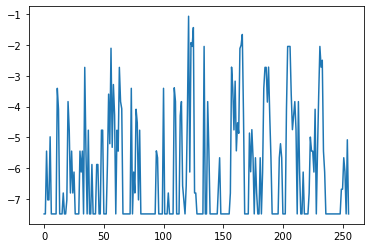

In [99]:
plt.plot(np.log(sfr_K))
# plt.yscale('log')

In [100]:
# sfr.write_file()

With no sfr K reduction, the model failed to converge in stress period 12 time step 3. With sfr K reduced by a factor of 1/100 the model ran to stress period 1246 time step 4 while the previous model with low K went to stress period 2026 time step 4. Dividing by 1000 actually caused the model to fail to converge at stress period 100 which shows that there was not enough water coming in to the aquifer from the stream, and 

In [385]:
mb4rl = pd.read_csv(sfr_dir+'michigan_bar_icalc4_data.csv', skiprows = 0, sep = ',')
# mb4rl.plot(x='gage_height_va',y='discharge_va', legend = False)
# plt.xlabel('Gage height (m)')
# plt.ylabel('Discharge $(m^3/d$)')
# plt.ticklabel_format(style='scientific') # plain to show all zeros
# plt.title('Simplified USGS Michigan Bar Rating Curve')
# plt.savefig('Plots/Model_SFR_UZF_Progress/MB_ratingcurve', dpi = 300, bbox_inches='tight')

In [102]:
# strtest_KsRep_array = fill_uzf(grid_uzf.Ksat_Rep, grid_uzf)
# plt.plot(sfr.reach_data.strhc1, label = 'Strm VKA')
# # plt.plot(strtest_KsRep_array[sfr.reach_data.i, sfr.reach_data.j], label = 'Strm HK')
# plt.plot(upw.vka.array[0,sfr.reach_data.i, sfr.reach_data.j], label = 'Aq VKA')
# plt.legend()
# plt.show()
# plt.title('Ksat_Rep divided by Ksat_Low from Soil map')
# plt.plot(strtest_KsRep_array[sfr.reach_data.i, sfr.reach_data.j]/sfr.reach_data.strhc1)

## Define segment data

Median grain size (mm) ranges from 1 mm – 30 mm along surveyed sites, which gives a range of 0.026-0.035 for a stable channel
Moderate channel irregularity due to channel scouring and pools alternating, range of 0.006-0.010
Gradual cross section change: 0.000 adjustment
Effect of obstructions: minor due to occasional downed logs and debris in river, 0.005-0.015
Amount of vegetation: large on banks due to willows and cottonwood trees, 0.025-0.050, and negligible in the channel
Degree of meandering: minor due to levees, m = 1.0

n = (nb+n1+n2+n3+n4)*m (b=base,1=surface irregularity, 2 = XS variation, 3 = obstructions, 4 = vegetation, m = correction for meandering)
n = (0.03+0.08+0.01) = 0.048 in channel
n = (0.048 +0.03) = 0.078 on banks


In [386]:
sfr_seg = sfr.segment_data[0].copy()

In [387]:
# There is one dictionary key for each stress period (starting at 0) and in each dictionary key there is a 
# rec array holding an entry for each stream segment where nseg shows which segment it is (ie no dictionary key for segment)
# If ITMP = 0 Item 4 is used, if ITMP >0 Item 6 is used, 
# if ITMP <0 the stream segment data not defined in Item 4 will be reused form the last stress period

# Define stress period data need one for each stress period
# Dataset 5 will be built automatically from segment_data unless specified
# ITMP (int) for reusing or reading stream seg data that can change each stress period
#IRDFLG, 0 is input data printed, greater than 0 input data is not printed
# doesn't seem to change the value
# IPTFLG, 0 is streamflow-routing results printed, greater than 0 not

In [105]:
# 15.0=14, 16.2 = 15, 16.4 = 16, 16.5 = 17, 17.0=18
# 14 outseg will be the side channel (16), 15 is the diversion before the Dam from 14 iupseg
# outseg for 15 will be -1 for the lake representing BLodgett Dam
# there is a diversion from 15 (segment to Dam) to 16 (side channel) to correct for the flood diversion
# so that below 500 cfs flow only goes to the side channel and above 500 cfs flow is 80% to Dam and 20% to side channel
# based on the idea that the side channel has a XS roughly 1/4 the size of the main channel and under high flows there
# will be more depth and force that flow will most likely be dominantly straight and avoid the side channel more

# if scenario =='actual':
#     pre_seg = XSg.loc[XSg.Site==16.2,'iseg'].iloc[0]
#     side_seg = XSg.loc[XSg.Site==16.4,'iseg'].iloc[0]
# elif (scenario =='actual') | (scenario=='design'):
#     post_seg = XSg.loc[XSg.Site==16.5,'iseg'].iloc[0]
# print(pre_seg,side_seg,post_seg)

In [388]:
# alternate version of segment data loading using if statements when filtering data rather than in a loop
sfr_seg.nseg = np.arange(1,NSS+1)

sfr_seg.icalc = 2 # Mannings and 8 point channel XS is 2 with plain MF, 5 with SAFE
sfr_seg.icalc[0] = 4 # use stage, discharge width method for Michigan Bar (nseg=1)
sfr_seg.nstrpts[sfr_seg.icalc==4] = len(mb4rl) # specify number of points used for flow calcs
sfr_seg.outseg = sfr_seg.nseg+1 # the outsegment will typically be the next segment in the sequence
sfr_seg.iupseg = 0 # iupseg is zero for no diversion
# correct outseg and iupseg to account for Blodgett Dam scenario
# if scenario =='design':
#     sfr_seg.outseg[sfr_seg.nseg==post_seg-1]=-1 # segment before dam flows to lake
#     sfr_seg.iupseg[sfr_seg.nseg==post_seg]=-1 # lake outflow is diverted to segment after dam
# elif scenario == 'actual':
#     sfr_seg.outseg[sfr_seg.nseg==pre_seg-1] = side_seg # the river should flow to the side segment first
#      # there will be a diversion from the river to the dam above 500 cfs, of which 20% will be returned to the side channel
#     sfr_seg.iupseg[sfr_seg.nseg==pre_seg] = pre_seg-1
#     sfr_seg.iprior[sfr_seg.nseg==pre_seg] = -3 # iprior=-3 any flows above the flow specified will be diverted
#     sfr_seg.flow[sfr_seg.nseg==pre_seg] = 500*0.3048*86400 # 500 cfs is the start of higher flow in the Cosumnes
#     sfr_seg.outseg[sfr_seg.nseg==pre_seg] = -1 #outflow from short segment before Dam is the LAK for the dam

#     # adjust for flow from pre dam segment back to side channel
#     sfr_seg.iupseg[sfr_seg.nseg==side_seg] = pre_seg
#     sfr_seg.iprior[sfr_seg.nseg==side_seg] = -2 # the flow diverted is a % of the total flow in the channel
#     sfr_seg.flow[sfr_seg.nseg==side_seg] = 0.2 # the side channel is about 1/4 the size so 20% of flow should run through
#     # divert flow from lake back into the segment after the dam
#     sfr_seg.iupseg[sfr_seg.nseg==post_seg] = -1 # no need to change iprior because diversion is based on lake stage
    
# set a flow into segment 1 for the steady state model run
sfr_seg.flow[0] = 2.834*86400. # m3/day, originally 15 m3/s
# set the values for ET, runoff and PPT to 0 as the inflow will be small relative to the flow in the river
sfr_seg.runoff = 0.0
sfr_seg.etsw = 0.0
sfr_seg.pptsw = 0.0

# Manning's n data comes from Barnes 1967 UGSS Paper 1849 and USGS 1989 report on selecting manning's n
# RoughCH is only specified for icalc = 1 or 2
sfr_seg.roughch[(sfr_seg.icalc==1) | (sfr_seg.icalc==2)] = 0.048
# ROUGHBK is only specified for icalc = 2
sfr_seg.roughbk[(sfr_seg.icalc==2) | (sfr_seg.icalc==5)] = 0.083# higher due to vegetation

In [389]:
sfr.segment_data[0] = sfr_seg

In [390]:
# Pull out data for upstream and downstream reach of each segment
up_data = xs_sfr.drop_duplicates('iseg')
dn_data = xs_sfr.sort_values('reach_new',ascending = False).drop_duplicates('iseg').sort_values('iseg')


# Need to return to later and remove hard coding
# These are getting used for initial guesses
# Read in first stress period when ICALC = 1 or 2 and ISFROPT is 5
# Dataset 6b
sfr.segment_data[0].hcond1 = sfr.reach_data.strhc1[0]
sfr.segment_data[0].thickm1 = 2
sfr.segment_data[0].elevup = up_data.z.values
sfr.segment_data[0].width1 = 20
sfr.segment_data[0].depth1 = 1
sfr.segment_data[0].thts1 = 0.4
sfr.segment_data[0].thti1 = 0.15
sfr.segment_data[0].eps1 = 4
sfr.segment_data[0].uhc1 = sfr.reach_data.strhc1[0]

# Dataset 6c
sfr.segment_data[0].hcond2 = sfr.reach_data.strhc1[-1]
sfr.segment_data[0].thickm2 = 2
sfr.segment_data[0].elevdn = dn_data.z.values
sfr.segment_data[0].width2 = 20
sfr.segment_data[0].depth2 = 1
sfr.segment_data[0].thts2 = 0.4
sfr.segment_data[0].thti2 = 0.15
sfr.segment_data[0].eps2 = 4
sfr.segment_data[0].uhc2 = sfr.reach_data.strhc1[-1]


In [391]:
# Change column name to float type for easier referencing in iteration
XS8pt.columns = XS8pt.columns.astype('float')
# Pre-create dictionary to be filled in loop
sfr.channel_geometry_data = {0:{j:[] for j in np.arange(2,len(XSg)+2)}  }

xsnum = 2
for k in XSg.Site.values:
        pos = int(XS8pt.columns.get_loc(k))
        XCPT = XS8pt.iloc[:,pos].values
        ZCPT = XS8pt.iloc[:,pos+1].values
        ZCPT_min = np.min(ZCPT)
        ZCPT-= ZCPT_min
        sfr.channel_geometry_data[0][xsnum] = [XCPT, ZCPT]
        xsnum += 1



In [392]:
FLOWTAB = mb4rl.discharge_va.values
DPTHTAB = mb4rl.gage_height_va.values
WDTHTAB = mb4rl.chan_width.values
sfr.channel_flow_data = {0: {1: [FLOWTAB, DPTHTAB, WDTHTAB]}}

In [111]:
# sfr.plot_path(start_seg=1, end_seg=0, plot_segment_lines=True)
# plt.savefig('Plots/Model_SFR_UZF_Progress/sfr_elev_vs_model_top.png', dpi = 600, bbox_inches='tight')

### Tab Files for SFR

In [565]:
# For the tab files the left column is time (in model units) and the right column is flow (model units)
# Time is days, flow is cubic meters per day
# USGS presents flow in cfs (cubic feet per second)
inflow = pd.read_csv(sfr_dir+'MB_daily_flow_cfs_2010_2019.csv', index_col = 'datetime', parse_dates = True)

# filter out data between the stress period dates
inflow = inflow.loc[strt_date:end_date]
# covnert flow from cubic feet per second to cubic meters per day
inflow['flow_cmd'] = inflow.flow_cfs * (86400/(3.28**3))

# # np.arange(0,len(flow_cmd))
time_flow = np.vstack((np.arange(1,len(inflow.flow_cmd)+1),inflow.flow_cmd))
time_flow = np.transpose(time_flow)
# add a first row to account for the steady state stress period
time_flow = np.row_stack(([0, inflow.flow_cmd.mean()], time_flow))

np.savetxt(model_ws+'/MF.tab',time_flow, delimiter = '\t')

In [394]:
flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'tab',unitnumber = 56)

Outside Package class

## LAK package

In [395]:
lak_extent = gpd.read_file(gwfm_dir+'/Blodgett_Dam/geospatial/bathymetry_extent/bathymetry_extent.shp')
lak_extent.crs

DriverError: PROJ: proj_create_from_wkt: Cannot find proj.db

In [ ]:
# if (scenario == 'actual') | (scenario == 'design'):
#     lak_buf = lak_extent.copy()
#     lak_buf.geometry = lak_buf.buffer(100)
#     # grid_sfr.drop('index_right',axis=1)
#     # gpd.sjoin(grid_c_nums, lak_buf, how='left',op='contains').plot()
#     lak_grid = gpd.overlay(grid_p, lak_extent, how='intersection')
#     # get cells with more than 1/3 of Blodgett Dam "lake extent"
#     lak_grid = lak_grid.loc[lak_grid.geometry.area > delr[lak_grid.row]*delr[lak_grid.column]/3]

#     # Set empty array of zeros for nonlake cells
#     lakarr = np.zeros((nlay, nrow,ncol))
#     # Each lake is given a different integer, and needs to be specified depending on the layer
#     lakarr[0,(lak_grid.row.values-1).astype(int),(lak_grid.column.values-1).astype(int)] = 1

#     bdlknc = np.zeros(( nrow,ncol))
#     # set blodgett dam Ksat same as stream Ksat at same location, leakance is K/lakebed thickness
#     lkbd_thick = sfr.reach_data.strthick[XSg.loc[XSg.Site==16.5].reach]
#     lkbd_K = sfr_K[XSg.loc[XSg.Site==16.5].reach]
#     bdlknc[(lak_grid.row.values-1).astype(int),(lak_grid.column.values-1).astype(int)] = lkbd_K/lkbd_thick

#     lakeRst = rasterio.open(gwfm_dir+'/Blodgett_Dam/geospatial/DEMs/hecras_1m_bathymetry.tif')
#     lakeBottom = lakeRst.read(1)
#     noDataValue = np.copy(lakeBottom[0,0])
#     #replace value for np.nan
#     lakeBottom[lakeBottom==noDataValue]= np.nan
#     # the stage for the stream section just after the dam is 23.04 m thus the bottom of the lake must be set 10 ft below that
#     lakeBottom = lakeBottom - 10
#     lakeBottom *= 0.3048

#     # get raster minimum and maximum 
#     minElev = np.nanmin(lakeBottom)
#     maxElev = np.nanmax(lakeBottom)
#     print('Min bottom elevation %.2f m., max bottom elevation %.2f m.'%(minElev,maxElev))

#     # steps for calculation
#     nSteps = 151

#     # lake bottom elevation intervals
#     elevSteps = np.round(np.linspace(minElev,maxElev,nSteps),2)


#     # definition of volume function
#     def calculateVol_A(elevStep,elevDem,lakeRst):
#         tempDem = elevStep - elevDem[elevDem<elevStep]
#         tempArea = len(tempDem)*lakeRst.res[0]*0.3048*lakeRst.res[1]*0.3048
#         tempVol = tempDem.sum()*lakeRst.res[0]*0.3048*lakeRst.res[1]*0.3048
#         return(tempVol, tempArea)
#     # calculate volumes, areas for each elevation
#     volArray = [0]
#     saArray = [0]
#     for elev in elevSteps[1:]:
#         tempVol,tempArea = calculateVol_A(elev,lakeBottom,lakeRst)
#         volArray.append(tempVol)
#         saArray.append(tempArea)


    # print("Lake bottom elevations %s"%elevSteps)
    # volArrayMCM = [round(i/1000000,2) for i in volArray]
    # print("Lake volume in million of cubic meters %s"%volArrayMCM)

In [116]:
# if (scenario == 'actual') | (scenario == 'design'):
#     # Exactly 151 lines must be included within each lake bathymetry input file and each line must contain 1 value 
#     #  of lake stage (elevation), volume, and area (3 numbers per line) if the keyword “TABLEINPUT” is specified in item 1a.
#     # A separate file is required for each lake. 

#     stages = minElev+0.1
#     # (ssmn, ssmx) max and min stage of each lake for steady state solution, there is a stage range for each lake
#     # so double array is necessary
#     stage_range = [[minElev, maxElev]]

#     # lake stage (elevation), volume, and area (3 numbers per line)
#     lak_depth = elevSteps - elevSteps[0]
#     bathtxt = np.column_stack((elevSteps, volArray, saArray))

#     np.savetxt(m.model_ws+'/MF_child.txt', bathtxt, delimiter = '\t')


#     ## Need to specify flux data
#     # Dict of lists keyed by stress period. The list for each stress period is a list of lists,
#     # with each list containing the variables PRCPLK EVAPLK RNF WTHDRW [SSMN] [SSMX] from the documentation.
#     # flux_data = np.zeros((nrow,ncol))

#     flux_data = {0:{0:[0,0,0,0]}}
#     # filler value for bdlknc until soil map data is loaded by uzf
#     lak = flopy.modflow.ModflowLak(model = m, lakarr = lakarr, bdlknc = bdlknc,  stages=stages, 
#                                    stage_range=stage_range, flux_data = flux_data,tabdata= True, 
#                                    tab_files='MF.txt', tab_units=[57],ipakcb=55)

#     # the lak package doesn't specify the tab file unit number when the files are written
#     # example:      110.0     100.0     170.0   22   Item 3:  STAGES,SSMN,SSMX,IUNITLAKTAB

#     lak.options = ['TABLEINPUT']

#     # need to reset tabdata as True before writing output for LAK
#     lak.tabdata = True

In [117]:
# m.remove_package('LAK')
# flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'txt',unitnumber = 57)

## Lak Gage Package

In [118]:
# if (scenario == 'actual') | (scenario == 'design'):
#     # numgage is total number of gages
#     # gage_data (list, or array), includes 2 to 3 entries (LAKE UNIT (OUTTYPE)) for each LAK entry
#     #  4 entries (GAGESEG< GAGERCH, UNIT, OUTTYPE) for each SFR package entry

#     lak_gage_data = [[-1, -37, 1]]
#     lak_file = 'MF.lak.gage'
#     lak_file_out = 'MF.lak.gage.out'
#     gag = flopy.modflow.ModflowGage(model=m,numgage= 1,gage_data=lak_gage_data,file =[lak_file_out], filenames =[lak_file])


"When subsurface recharge (MBR2) is negligible,
stream runoff at the mountain front (runoff measured at
point B in Figure 1, or RO) may be considered the total
contribution to MFR [Anderholm, 2000]." (Wilson and Guan 2004)

## GHB NW, SE set up

In [396]:
# join top and botm for easier array referencing for elevations
top_botm = np.zeros((m.dis.nlay+1,m.dis.nrow,m.dis.ncol))
top_botm[0,:,:] = m.dis.top.array
top_botm[1:,:,:] = m.dis.botm.array


In [397]:
# get hydraulic conductivities 
ghb_hk_nw = scaling_factors.loc[0,'K_nw']*86400
ghb_hk_se = scaling_factors.loc[0,'K_se']*86400

In [650]:
distance = 5000
t0 = time.time()

col_strt=1

ghbnw_spd = pd.DataFrame(np.zeros((np.sum(nlay-nw_lay[col_strt:]),5)))
ghbnw_spd.columns = ['k','i','j','bhead','cond']
# start 1 column in to avoid conflict with delta boundary

# get all of the j,k indices to reduce math done in the for loop
yz = np.zeros((np.sum(nlay-nw_lay[col_strt:]),2)).astype(int)
n=0
for j in np.arange(col_strt,ncol):
    for k in np.arange(nw_lay[j], nlay):
        yz[n,0] = j
        yz[n,1] = k
        n+=1
        
condnw = hk[yz[:,1],0,yz[:,0]]*(top_botm[yz[:,1],0,yz[:,0]]-top_botm[yz[:,1]+1,0,yz[:,0]])*delr/distance
# condnw = ghb_hk_nw*(top_botm[yz[:,1],0,yz[:,0]]-top_botm[yz[:,1]+1,0,yz[:,0]])*delr/distance

ghbnw_spd.cond = condnw
ghbnw_spd.bhead = avg_nw[yz[:,0]]
ghbnw_spd.k = yz[:,1]
ghbnw_spd.j = yz[:,0]
ghbnw_spd.i = 0

ghbse_spd = pd.DataFrame(np.zeros((np.sum(nlay-se_lay[col_strt:]),5)))
ghbse_spd.columns = ['k','i','j','bhead','cond']

# get all of the j,k indices to reduce math done in the for loop
yz = np.zeros((np.sum(nlay-se_lay[col_strt:]),2)).astype(int)
n=0
for j in np.arange(col_strt,ncol):
    for k in np.arange(se_lay[j], nlay):
        yz[n,0] = j
        yz[n,1] = k
        n+=1
condse = hk[yz[:,1],int(nrow-1),yz[:,0]]*(top_botm[yz[:,1],-1,yz[:,0]]-top_botm[yz[:,1]+1,-1,yz[:,0]])*delr/distance
# condse = ghb_hk_se*(top_botm[yz[:,1],-1,yz[:,0]]-top_botm[yz[:,1]+1,-1,yz[:,0]])*delr/distance

ghbse_spd.cond = condse
ghbse_spd.bhead = avg_se[yz[:,0]]
ghbse_spd.k = yz[:,1]
ghbse_spd.j = yz[:,0]
ghbse_spd.i = nrow-1
        
resample_time = time.time() - t0
print("GHB time: {:.3f} sec".format(time.time() - t0))

GHB time: 0.007 sec


In [652]:
# only need to recalculate conductance in ucode
def recalc_cond(i,j,k,hk):
    distance = 5000
    delr = m.dis.delr.array.mean()
    cond = hk*(top_botm[k,i,j]-top_botm[k+1,i,j])*delr/distance
    return(cond)


## Southwest GHB boundary (specified head for outflow to the Delta)

How much would the expected head gradient be near the delta, how fast would head decrease with depth.
Perhaps it would only go down a few meters for every layer

In [653]:
distance = 5000
# Fine sand	2×10-7 to 2×10-4 m/s
# Silt, loess	1×10-9 to 2×10-5 m/s
# delta soils have some sand mixed in
# convert from m/s to m/d
delta_hk = scaling_factors.loc[0,'K_delta']*86400

ghbdelta_spd = pd.DataFrame(np.zeros(((nlay*nrow),5)))
ghbdelta_spd.columns = ['k','i','j','bhead','cond']

# get all of the j,k indices to reduce math done in the for loop
xz = np.zeros((nlay*nrow,2)).astype(int)
n=0
for i in np.arange(0,nrow):
    for k in np.arange(0, nlay):
        xz[n,0] = i
        xz[n,1] = k
        n+=1
cond = delta_hk*(top_botm[xz[:,1],:,0]-top_botm[xz[:,1]+1,:,0])*delr/distance
ghbdelta_spd.cond = cond
ghbdelta_spd.bhead = 0
ghbdelta_spd.k = xz[:,1]
ghbdelta_spd.j = 0
ghbdelta_spd.i = xz[:,0]

In [654]:
# write to csv for use in UCODE file edits
ghbse_spd.to_csv(m.model_ws+'/input_data/ghbse_spd.csv',index=False)
ghbnw_spd.to_csv(m.model_ws+'/input_data/ghbnw_spd.csv',index=False)
ghbdelta_spd.to_csv(m.model_ws+'/input_data/ghbdelta_spd.csv',index=False)

In [655]:
# lay, row, col for delta ghb
zxy = ghbdelta_spd.values[:,:3].astype(int)
# drop any delta ghb cells where cell bottom is below sea level
ghbdn_spd =  ghbdelta_spd.values[botm[zxy[:,0],zxy[:,1],zxy[:,2]]<0]
# join dataframes of 3 ghb boundaries together
ghb_spd = np.vstack((ghbdn_spd, ghbse_spd.values, ghbnw_spd.values))


In [656]:
# # lay, row, col, head, cond
# k = ghb_spd[:,0].astype(int)
# i = ghb_spd[:,1].astype(int)
# j = ghb_spd[:,2].astype(int)

# # find where the ghb overlaps with the no flow cells
# active_bc =bas.ibound.array[k,i,j]
# # ghb_spd = ghb_spd[active_bc.astype(bool)]

In [657]:
# ghb_spd = ghb_spd[:][active_bc.astype(bool)]

In [658]:

# GHB for east and west model boundaries
ghb = flopy.modflow.ModflowGhb(model=m, stress_period_data =  {0: ghb_spd},ipakcb=55)
# GHB for only Delta, west side of model
# ghb.stress_period_data =  {0: ghbdn_spd}

In [659]:
ghb.check()


GHB PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells
    BC elevation below cell bottom



In [660]:
# ghb.write_file()

## CHD Package Time variant head

In [508]:
chd = flopy.modflow.ModflowChd(model=m,ipakcb=55)

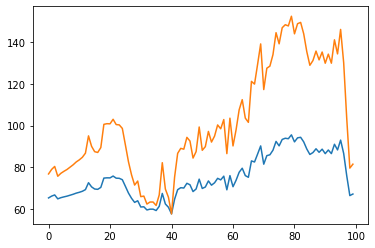

In [720]:
# Determine which layer the specified head cell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# otherwise it would be less than and zero (most should be in layer 0)
chd_lay = np.zeros(nrow)

head = dem_data[:,ncol-1]
headmin = np.min(head)
ch_weight = 0.6
chd_vals = head*(1-ch_weight)+headmin*ch_weight

kriged_mtn = np.vstack((kriged_spring[:,:,ncol-1], kriged_fall[:,:,ncol-1]))
kriged_mtn_df = pd.DataFrame(np.rot90(kriged_mtn),columns=sy_ind)

fig,ax=plt.subplots( figsize=(6,4))
# kriged_mtn_df.loc[:,'spring'].plot(ax=ax,linestyle='--')
# kriged_mtn_df.loc[:,'fall'].plot(ax=ax)
ax.plot(chd_vals)
ax.plot(dem_data[:,ncol-1])

for k in np.arange(0,nlay-1):
    # pull out elevation of layer bottom
    lay_elev = botm[k, :, ncol-1]
    for i in np.arange(0,nrow):
        # want to compare if streambed is lower than the layer bottom
        # 1 will be subtracted from each z value to make sure it is lower than the model top in the upper reaches
        if lay_elev[i] > chd_vals[i]:
            chd_lay[i] = k



In [510]:
# layer (int), row (int), column (int), shead (float), ehead (float) shead is the head at the
# start of the stress period, and ehead is the head at the end of the stress period
# nlay_ghb = 1

# constant head boundary for mountain front recharge
# assume that near the mountains the head should be at the surface becaues the aquifer is thin

# new specified head boundary will be linear at the uppermost column to reduce nonlinearity
# as the no flow cells will be removed and replaced with low hydraulic conductivity cells

# chd_spd = np.zeros((len(chd_locs[0]),5))
chd_spd = np.zeros((int(np.sum((nlay-chd_lay))),5))

# # head for mountain front recharge
shead = chd_vals
ehead = chd_vals
p=0
for i in np.arange(0,nrow):
    for k in np.arange(0,nlay-chd_lay[i]):
        chd_spd[p] = [int(chd_lay[i]+k), i, ncol-1, shead[i], ehead[i]]
        p+=1
print('Number of CHD cells for upland bound', p)

# p = 0
# # head for mountain front recharge
# shead = head
# ehead = head

# for i, j in zip(chd_locs[0], chd_locs[1]):
#     chd_spd[p] = [0, i, j, shead[p], ehead[p]]
#     p+=1
# print('Number of CHD cells for upland bound', p)


Number of CHD cells for upland bound 2100


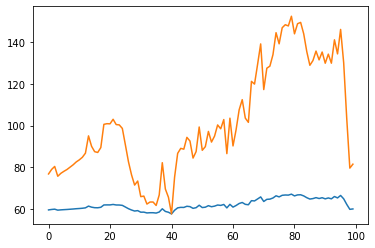

In [716]:
kriged_mtn = np.vstack((kriged_spring[:,:,ncol-1], kriged_fall[:,:,ncol-1]))
kriged_mtn_df = pd.DataFrame(np.rot90(kriged_mtn),columns=sy_ind)

fig,ax=plt.subplots( figsize=(6,4))
# kriged_mtn_df.loc[:,'spring'].plot(ax=ax,linestyle='--')
# kriged_mtn_df.loc[:,'fall'].plot(ax=ax)
ax.plot(chd_vals)
ax.plot(dem_data[:,ncol-1])

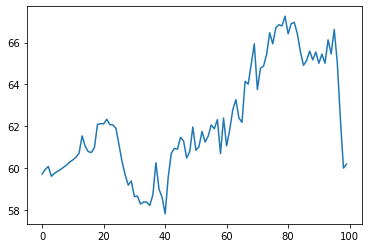

In [512]:
chd.stress_period_data =  {0: chd_spd}

In [513]:
chd.check()


CHD PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells



The code that originally imported the state soil map data was moved up above to be readily applicable to the LAK package and SFR package. gpd_mb and grid_uzf are created above

## RCH Package
1. Load in already interpolated ET and rainfall data
2. Determine where there is agricultural land to add irrigation multiplied by an efficiency factor to the rainfall array
3. Difference the rainfall and ETc arrays to dtermine how much water will recharge the aquifer

In [514]:
ETc = np.zeros((nper-1,nrow,ncol))
rain = np.zeros((nper-1,nrow,ncol))

ETc_count = 0
for y in np.arange(pd.to_datetime(strt_date).year, pd.to_datetime(end_date).year+1):
    # set start and end date for range for the year to be iterated over
    yr_strt = pd.to_datetime(str(y)+'-01-01')
    yr_end = pd.to_datetime(str(y)+'-12-31')
    # get the length of the date range needed for that year
    yearlen = len(pd.date_range(yr_strt, yr_end))
    if yr_strt < pd.to_datetime(strt_date):
        yr_strt = pd.to_datetime(strt_date)
    if yr_end > pd.to_datetime(end_date):
        yr_end = pd.to_datetime(end_date)
        
    # read in text file of all of the ETc data for each year in array format    
    ET_year = np.loadtxt(gwfm_dir+'/UZF_data/ETa_all_txt_arrays/ETa_array_'+str(y)+'.tsv', delimiter = '\t')
    rain_year = np.loadtxt(gwfm_dir+'/UZF_data/Rain_all_txt_arrays/Rain_array_'+str(y)+'.tsv', delimiter = '\t')

    # correct the shape of the text file from 2D to 3D
    revertETc = np.reshape(ET_year, (yearlen, nrow, ncol))
    revertrain = np.reshape(rain_year, (yearlen, nrow, ncol))
    # filter the 3D array based on the desired date range
    filtered_date_ETc = revertETc[yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
    filtered_date_rain = revertrain[yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
    # get the length of the date range needed for that year
    perlen = len(pd.date_range(yr_strt, yr_end))
    # add the data to the ETc array for the whole model time period
    ETc[ETc_count:ETc_count+perlen,:,:] = filtered_date_ETc
    rain[ETc_count:ETc_count+perlen,:,:] = filtered_date_rain
    ETc_count += perlen

In [781]:
rain.shape, 1096*100*230, np.isnan(rain).sum()/ (1096*100*230),np.where(np.isnan(rain))[0]
pd.to_datetime(strt_date)+pd.DateOffset(days=457),pd.to_datetime(strt_date)+pd.DateOffset(days=726)
# missing data from 2020-1-1 to 2020-9-26

((1096, 100, 230),
 25208000,
 0.08828982862583307,
 array([457, 457, 457, ..., 726, 726, 726], dtype=int64))

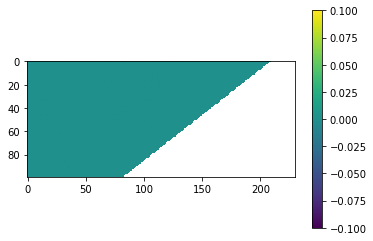

In [790]:
# plt.imshow(rain[457,:,:])
plt.imshow(rain[726,:,:])
plt.colorbar()

In [778]:
# pd.Series(pd.to_datetime(strt_date) ) +pd.DateOffset(days=np.asarray([1, 2]))
#pd.DateOffset
# pd.DateOffset(days=pd.Series(np.where(np.isnan(rain))[0]))
pd.to_datetime(strt_date)+np.where(np.isnan(rain))[0].astype('timedelta64[D]')
# np.where(np.isnan(rain))[0]

array(['2020-01-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000', ...,
       '2020-09-26T00:00:00.000000000', '2020-09-26T00:00:00.000000000',
       '2020-09-26T00:00:00.000000000'], dtype='datetime64[ns]')

In [733]:
np.isnan(rain).sum()

2225610

In [515]:

# logical array where 1 represents ag land and 0 represents non ag land as listed above
ag_land_arr = np.loadtxt(gwfm_dir+'/UZF_data/array_of_agriculture_land.tsv')
# create a bool array of the oppostite of ag land
non_ag_land_arr = ~ag_land_arr.astype(bool)

In [516]:
# wherever there is ag land and not enough rain to meet the ETc then it will be met by applying 1.05*ETc
# to the .FINF array
# start by setting the rain of non_ag_land to np.nan to be ignored in calculations
ag_rch = np.copy(rain)
ag_rch[:,non_ag_land_arr] = np.nan
# whereever the rain is less than ETc for ag land set the recharge equal to the etc times 0.05 for irrigation inefficiency
# could calibrate this irrigation efficiency later
ag_rch[ag_rch<ETc] = ETc[ag_rch<ETc]*0.05
# return np.nan values to zeros
ag_rch[np.isnan(ag_rch)] = 0

In [517]:
# final calculation for RCH package

net_inf = rain + ag_rch - ETc
# assuming there is irrigation to make up lack of rainfall
# net_inf should never be less than zero
np.mean(net_inf, axis = (1,2))

net_inf = np.where(net_inf<0, 0, net_inf)


In [518]:
# add an empty array for the first blank stress period
# net_inf = np.vstack((np.zeros((1,nrow,ncol)),net_inf))

In [519]:
# have transient recharge start after the 1st spd
rech_spd = { (j): net_inf[j-1,:,:] for j in np.arange(1,nper)}

In [520]:
# set average recharge for whole period as steady state
rech_spd[0] = net_inf.mean(axis=(0))

In [728]:
rech_spd[0]

array([[0.00232415, 0.00230874, 0.00230245, ...,        nan,        nan,
               nan],
       [0.00233032, 0.00232967, 0.00226465, ...,        nan,        nan,
               nan],
       [0.00231554, 0.00223697, 0.00101424, ...,        nan,        nan,
               nan],
       ...,
       [0.00260564, 0.00257209, 0.00257285, ...,        nan,        nan,
               nan],
       [0.00257258, 0.00126128, 0.00257587, ...,        nan,        nan,
               nan],
       [0.00259998, 0.00251777, 0.00261416, ...,        nan,        nan,
               nan]])

In [521]:
# nrchop = 3, to highest active cell
rch =flopy.modflow.ModflowRch(model = m, nrchop=3, rech = rech_spd, ipakcb=55)

In [146]:
# rch.write_file()

## Well Package


In [522]:
wells = pd.read_csv(gwfm_dir+'/WEL_data/all_wells_type.csv')
wells_grid = gpd.GeoDataFrame(wells, geometry = gpd.points_from_xy(wells.easting,wells.northing), crs = 'epsg:32610')

In [523]:
wells_grid_ag = wells_grid.copy()
wells_grid_ag = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].dissolve('node', aggfunc = 'mean')
wells_grid_ag.geometry = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].dissolve('node', aggfunc = 'first').geometry

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207

In [524]:
wells_grid['depth_m'] = wells_grid.TotalCompletedDepth*0.3048


In [525]:
wells_grid['flux'] = 0
wells_grid['layer'] = 0

In [526]:
num_ag = (wells_grid.Simple_type == 'irrigation').sum()
ET_ag = ETc*ag_land_arr
ET_ag_monthly_sum = ET_ag.sum(axis=(1,2))
# calculate ag well flux by average ET
aggregated_irrig_flux = ET_ag_monthly_sum/num_ag


In [527]:
# assume each public supply well serves 5-10,000 people each needing 50 gpd, then need to convert to ft^3
public_flux = (5000*50/7.48)*(0.3048**3)
# public_flux = 1500*(1/7.48)*(0.3048**3)*60*24

# averge pumping rate of domestic wells is 10-100 gpm, typically on the lower end and 
# should end up being around 50 gal/person a day and average 3 people is 150 gal/day
# 10 gpm * (1 ft^3/ 7.48 gal) (ft^3/m^3)*60 min hour* 3 hours in a day * 30 days

dom_flux = 30*(1/7.48)*(0.3048**3)*60*24
print('Irrig flux:', '%.3e' % (aggregated_irrig_flux.mean()*270*270), 'Public flux:', '%.3e' %public_flux,'Domestic flux:', '%.3e' %dom_flux)

Irrig flux: 2.549e+03 Public flux: 9.464e+02 Domestic flux: 1.635e+02


In [528]:
# define pumping rate based on well use, average pumping rate in m^3/day
# wells_grid.loc[wells_grid.Simple_type == 'irrigation', 'flux'] = -irrig_flux
wells_grid.loc[wells_grid.Simple_type == 'domestic', 'flux'] = -dom_flux
wells_grid.loc[wells_grid.Simple_type == 'public', 'flux'] = -public_flux

In [529]:
if wells_grid.row.min()==1:
    wells_grid.row = (wells_grid.row-1).astype(int)
    wells_grid.column = (wells_grid.column -1).astype(int)

In [530]:
mean_ag_well_depth = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].TotalCompletedDepth.mean()*0.3048
mean_ag_well_depth

107.05973

In [531]:

for k in np.arange(0,nlay-1):
    # pull out elevation of layer bottom
    lay_elev = botm[k, :, :]
    for i in np.arange(0,len(wells_grid)):
        # want to compare if streambed is lower than the layer bottom
        # 1 will be subtracted from each z value to make sure it is lower than the model top in the upper reaches
        if lay_elev[wells_grid.row.values[i],wells_grid.column.values[i]] > dem_data[wells_grid.row.values[i],wells_grid.column.values[i]]-wells_grid.depth_m.iloc[i]:
            wells_grid.layer.iloc[i] = k     

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [532]:
print('Cells with wells: ', wells_grid.dissolve(by='node',aggfunc='first').shape[0], 'total wells: ', wells_grid.shape[0])
print('Wells with TRS accuracy: ', (wells_grid.MethodofDeterminationLL == 'Derived from TRS').sum())

wells_grid_notrs = wells_grid.loc[wells_grid.MethodofDeterminationLL != 'Derived from TRS']

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207

Cells with wells:  1380 total wells:  2482
Wells with TRS accuracy:  823


C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207

In [533]:
# wells_grid_notrs['count_per_cell'] = 1
# # all_wells_grid['MFCell'] = all_wells_grid.Township+all_wells_grid.Range+all_wells_grid.k.astype(str)
# wells_grid_sum = wells_grid_notrs.dissolve(by = 'node', aggfunc='sum')
# wells_grid_sum.plot('count_per_cell',legend=True)
# print(wells_grid_sum.count_per_cell.median(), wells_grid_sum.count_per_cell.mean(), wells_grid_sum.count_per_cell.max())


In [534]:
# save domestic, public wells for their pumping doesn't depend on ET
wells_grid_no_ag = wells_grid.loc[wells_grid.Simple_type != 'irrigation']
# filter out data for wel package
spd_noag = wells_grid_no_ag.loc[:,['layer','row','column', 'flux']].values


#### Using ETc in all cells for pumping

In [535]:
# layer for ETc ag well pumping
ETc_lay = 1
# create empty dictionary to fill with stress period data
wel_ETc_dict = {}
# end date is not included as a stress period, starting at 1st TR spd (2)
for t in np.arange(1,nper):
    wel_i, wel_j = np.where(ET_ag[t-1,:,:]>0)
    wel_ETc = -ET_ag[t-1,wel_i,wel_j]*delr*delr
    # ['layer','row','column', 'flux'] are necessary for WEL package
    spd_ag = np.stack((ETc_lay*np.ones(len(wel_i)), wel_i, wel_j,wel_ETc),axis=1)
    spd_all = np.vstack((spd_ag,spd_noag)) # join pumping from ag with point pumping from domstic/supply wells that are constant
    wel_ETc_dict[t] = spd_all

In [536]:
ET_ag_ss = ET_ag.mean(axis=(0))
wel_i, wel_j = np.where(ET_ag_ss[:,:]>0)
wel_ETc = -ET_ag_ss[wel_i,wel_j]*delr*delr
# ['layer','row','column', 'flux'] are necessary for WEL package
# add average ag well pumping as steady state period
wel_ETc_dict[0] = np.stack((ETc_lay*np.ones(len(wel_i)), wel_i, wel_j,wel_ETc),axis=1)

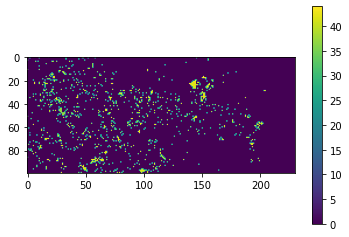

In [537]:
t=100
plt.imshow(ET_ag[t,:,:]*200*200)
plt.colorbar()

In [538]:
# Create well flopy object
wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_ETc_dict,ipakcb=55)

In [164]:
# wel.write_file()

In [165]:
# spd = { t: spd_gdf_array for t in np.arange(1,nper)}
# spd = { t: wells_grid_notrs.loc[:,['layer','row','column', 'flux']] for t in np.arange(1,nper)}
# spd = {}
# for t in np.arange(1,nper):
#     # create duplicate of dataframe
#     temp = wells_grid_notrs[:]
#     # set flux for all ag wells based on ET requirements downscaled
#     temp.loc[temp.Simple_type == 'irrigation'].flux = aggregated_irrig_flux[t-1]
#     # get wel package necessary data
#     spd[t] = temp.loc[:,['layer','row','column', 'flux']].dropna().values


In [166]:
# Create well flopy object
# wel = flopy.modflow.ModflowWel(m, stress_period_data=spd, ipakcb=55)

## HOB Package

In [540]:
hob_dir = gwfm_dir+'/HOB_data'

In [ ]:
# con_stations = pd.read_csv(ghb_dir+'/dwr_continuous_groundwater/gwlstations.csv')
# monthly = pd.read_csv(ghb_dir+'/dwr_continuous_groundwater/continuousgroundwatermonthly.csv')

In [543]:
stations = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/stations.csv')
periodic = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/measurements.csv')
stations_gpd = gpd.GeoDataFrame(stations,
                                geometry = gpd.points_from_xy( stations.LONGITUDE, stations.LATITUDE), crs = 'epsg:4326')
# need to use the domain in lat, long crs as some wells may edge in utm zone 11n
stations_gpd = gpd.sjoin(stations_gpd.to_crs('epsg:32610'),m_domain, how = 'inner', op = 'intersects')
# join the periodic measurements with the site locations 
domain_periodic = periodic.merge(stations_gpd, on = ['SITE_CODE'])

domain_periodic['MSMT_DATE']=pd.to_datetime(domain_periodic['MSMT_DATE'])
domain_periodic = domain_periodic.set_index('MSMT_DATE')
# filter to modern time
domain_periodic = domain_periodic.loc[domain_periodic.index>strt_date]

In [544]:
domain_periodic.columns

Index(['SITE_CODE', 'WLM_ID', 'WLM_RPE', 'WLM_GSE', 'GWE', 'GSE_GWE',
       'WLM_QA_DESC', 'WLM_DESC', 'WLM_ACC_DESC', 'WLM_ORG_NAME',
       'COOP_ORG_NAME', 'MONITORING_PROGRAM_x', 'MSMT_CMT', 'STN_ID', 'SWN',
       'WELL_NAME', 'LATITUDE', 'LONGITUDE', 'GSE', 'GSE_METHOD', 'GSE_ACC',
       'BASIN_CODE', 'BASIN_NAME', 'COUNTY_NAME', 'WELL_DEPTH', 'WELL_USE',
       'WELL_TYPE', 'WCR_NO', 'MONITORING_PROGRAM_y', 'geometry',
       'index_right', 'FID'],
      dtype='object')

In [546]:

# domain_periodic_2010s = pd.read_csv(hob_dir+'/dwr_gwe_data_2010s.csv', index_col = 'MSMT_DATE', parse_dates =True)
# filter out columns relevant to observation
domain_periodic_adj = domain_periodic.filter(['SITE_CODE', 'GWE', 'WLM_RPE','WLM_GSE',
                              'WLM_ACC_DESC','LATITUDE','LONGITUDE','WELL_DEPTH', 'WELL_TYPE'],axis=1)

# filter out measurements for the actual modeled period
dwr_obs = domain_periodic_adj.loc[strt_date:end_date]
# convert observations to geodataframe to merge with
dwr_obs_gpd = gpd.GeoDataFrame(dwr_obs, geometry = gpd.points_from_xy(dwr_obs.LONGITUDE,dwr_obs.LATITUDE))
dwr_obs_gpd.crs = 'epsg:4326'
dwr_obs_gpd = dwr_obs_gpd.to_crs('epsg:32610')
# the grid is a 1 based system
dwr_obs_grid = gpd.sjoin(dwr_obs_gpd,grid_p)

# convert units from ft to meters
dwr_obs_grid.loc[:,['GWE','WLM_RPE','WLM_GSE', 'WELL_DEPTH']] /=3.28
dwr_obs_grid = dwr_obs_grid.dropna(subset=['GWE'])

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  import sys


In [169]:
ucd_meta = pd.read_csv(hob_dir+'/Cosumnes_MW_metadata.csv')
ucd_mon = pd.read_csv(hob_dir+'/ucd_wells_monthly.csv', index_col = 'dt', parse_dates = True)
# filter out measurements for the actual modeled period
ucd_mon = ucd_mon.loc[strt_date:end_date]
# remove timezone component of date format
ucd_mon.index = ucd_mon.index.tz_localize(tz=None)
# melt dataframe by id and date
ucd_mon = ucd_mon.reset_index().melt(id_vars = ['dt'], value_vars=ucd_mon.columns)
ucd_mon = ucd_mon.rename({'variable':'Well_ID','value':'wse_m'},axis=1)

# remove TZ adjustment from dt


In [170]:
# convert observations to geodataframe to merge with
ucd_meta_gpd = gpd.GeoDataFrame(ucd_meta, geometry = gpd.points_from_xy(ucd_meta.LONGITUDE,ucd_meta.LATITUDE))
ucd_meta_gpd.crs = 'epsg:4326'
ucd_meta_gpd = ucd_meta_gpd.to_crs('epsg:32610')
# the grid is a 1 based system
ucd_meta_grid = gpd.sjoin(ucd_meta_gpd,grid_p)

# estimate GSE from RPE
ucd_meta_grid['WLM_GSE'] = ucd_meta_grid['MPE (meters)']-1

In [171]:
# simplify from 22 to 8 wells for now because there will be overfitting of wells at Oneto-Denier and 
# these wells all have LevelSenders allowing for easier data access
well_vertices = ucd_meta_grid.set_index('Well_ID').loc[['MW_DR1', 'MW_9', 'MW_11', 'MW_19','MW_5', 'MW_22','Rooney1']]

In [172]:
# join wse data with location and metadata
ucd_obs = ucd_mon.join(well_vertices, how = 'right',on = 'Well_ID')
ucd_obs = ucd_obs.dropna(subset=['wse_m']) # remove NA values

# prepare UCD obs for joining with DWR obs
ucd_obs = ucd_obs.set_index('dt').loc[:,['Well_ID','wse_m','WLM_GSE','node','row','column']].rename({'Well_ID':'SITE_CODE','wse_m':'WSE'},axis=1)

In [548]:
# join UCD and DWR obs
# all_obs = dwr_obs_grid.loc[:,['SITE_CODE','WSE','WLM_GSE','node','row','column']].append(ucd_obs)
all_obs = dwr_obs_grid.loc[:,['SITE_CODE','GWE','WLM_GSE','node','row','column']]
# make row and column 0 based
all_obs.row -= 1
all_obs.column -=1

In [550]:
# find DEM elevation and difference between measured and DEM
all_obs['dem_elev'] = dem_data[(all_obs.row).values.astype(int),(all_obs.column).values.astype(int)]
all_obs['dem_wlm_gse'] = all_obs.dem_elev - all_obs.WLM_GSE
# recalculate WSE based on DEM elevation
all_obs['wse_m_adj'] = all_obs.dem_elev - (all_obs['WLM_GSE'] - all_obs.GWE)

# get spd corresponding to dates
all_obs['spd'] = (all_obs.index-pd.to_datetime(strt_date)).days.values


29.41 % of the sites have a difference > 1 m


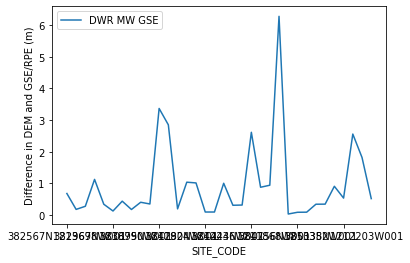

In [551]:
# dwr_obs_grid['dem_wlm_gse'] = dwr_obs_grid.dem_elev - dwr_obs_grid.WLM_GSE
# ucd_meta_grid['dem_elev'] = dem_data[(ucd_meta_grid.row-1).values.astype(int),(ucd_meta_grid.column-1).values.astype(int)]
# ucd_meta_grid['dem_rpe'] = ucd_meta_grid.dem_elev - ucd_meta_grid['MPE (meters)']
# aggregate by site id and then plot to look at difference
temp = all_obs.groupby('SITE_CODE').aggregate( func = 'mean').dem_wlm_gse.abs()
temp.plot(label = 'DWR MW GSE')
# ucd_meta_grid['dem_wlm_gse'].plot(label = 'UCD MW RPE')
plt.legend()
max_diff = 1
plt.ylabel('Difference in DEM and GSE/RPE (m)')
print('%.2f'%(((temp>max_diff).sum()/temp.shape)[0]*100) ,'% of the sites have a difference >', max_diff,'m' )

UCD Monitoring wells differences  
MWDR1 (-6m), MW UCD26(-2m), MW23 (-1m) and MWCP1 (-2m) have the worst errors

In [552]:
dwr_site_codes = all_obs.SITE_CODE.unique()


In [553]:
all_obs['obs_nam'] = all_obs.node.astype(str)
# use the model grid node number to shorten the dwr_site code name
nodes = all_obs.obs_nam.unique()

for i in np.arange(0,len(nodes)):
    # find matching observations to the unique node
    df = all_obs.loc[all_obs.obs_nam==nodes[i]]
    # check ndim for counting number of obs per node
    if df.ndim >1: nobs = len(df)
    else: nobs=1    
    for n in np.arange(0,nobs):
        df.obs_nam.iloc[n] = 'N'+df.obs_nam.iloc[n]+'.'+str(n+1).zfill(5)
#     # reset node name in dwr_obs
    all_obs.loc[all_obs.obs_nam==nodes[i],:] = df.copy()
    

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [555]:
# create a new hob object
obs_data = []
dwr_spd_wse = all_obs.loc[:,['SITE_CODE','spd','GWE']]
for i in np.arange(0,len(dwr_site_codes)): # for each well location
    # time_series_data needs stress period in col 0 and WSE in col 1
    # the row and column are already one based as they come from grid_p
    # need to return and adjust layer later, for now layer 2 should be good so that it doesn't go dry
    # get stress period data and water surface elevation for well
    dwr_site = all_obs.set_index('SITE_CODE').loc[dwr_site_codes[i]]
    if dwr_site.ndim >1:
        row = dwr_site.row.values[0]
        col = dwr_site.column.values[0]
        names = dwr_site.obs_nam.tolist()
        obsname = 'N'+str(dwr_site.node.values[0])
    else:
        row = dwr_site.row
        col = dwr_site.column
        names = dwr_site.obs_nam
        obsname = 'N'+str(dwr_site.node)
        
    tsd = dwr_spd_wse.set_index('SITE_CODE').loc[dwr_site_codes[i]].values
    # need to minus 1 for grid_p which is 1 based
    temp = flopy.modflow.HeadObservation(m, layer=2, row=row, 
                                                  column=col,
                                                  time_series_data=tsd,
                                                  obsname=obsname, names = names)
    # correct time offset from stress period to be 0
    temp.time_series_data['toffset'] = 0
    obs_data.append(temp)


In [556]:
hob = flopy.modflow.ModflowHob(m, iuhobsv=50, hobdry=-9999., obs_data=obs_data, unitnumber = 39,
                              hobname = 'MF.hob.out')

In [180]:
# hob.write_file()

## Output Control

In [557]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# For later model runs when all the data is needed to be saved
spd = { (j,0): ['save head', 'save budget'] for j in np.arange(0,nper,1)}

# get the first of each month to print the budget
month_intervals = (pd.date_range(strt_date,end_date, freq="MS")-pd.to_datetime(strt_date)).days

for j in month_intervals:
    spd[j,0] = ['save head', 'save budget','print budget']
    
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

## Newton Solver

In [182]:
# m.version = 'mfnwt'
# m.exe_name = 'mf-nwt.exe'

In [183]:
# pcg = flopy.modflow.ModflowPcg(model = m)
# nwt = flopy.modflow.ModflowNwt(model= m)
# thickfact: portion of cell thickness used for smoothly adjusting storage and conductance coefficients to zero (default is 1e-5)
# linmeth (linear method): 1 for GMRES and 2 for XMD (1 is default)
# iprnwt: flag whether additional info about solver convergence will be printed to the main listing file (default is 0)
# ibotav: flag whether corretion will be made to gw head relative to cell-bottom if surrounded by dry cells.
# 1 = corrections and  0 = no correction (default is 0)
# options: specify comlexity of solver. SIMPLE : default solver for linear models, MODERATE for moderately nonlinear models,
# COMPLEX for highly nonlinear models (default is COMPLEX)
# Continue: if model fails to converge during a time step it will continue to solve the next time step (default is False) 
# epsrn (XMD) is the drop tolerance for preconditioning (default is 1E-4)
# hclosexmd (XMD) head closure criteria for inner (linear) iterations (default 1e-4)

# solver = flopy.modflow.ModflowNwt(model = m, headtol=0.01, fluxtol=500, maxiterout=200, thickfact=1e-05, 
#                                linmeth=1, iprnwt=1, ibotav=0, options='MODERATE', Continue=False,
#                                maxbackiter=50, backtol=1.1, maxitinner=50, ilumethod=2, 
#                                levfill=5, stoptol=1e-10, msdr=15, iacl=2, norder=1, level=5, north=7, 
#                                iredsys=0, rrctols=0.0, idroptol=1, epsrn=0.0001, hclosexmd=0.0001, 
#                                mxiterxmd=50, extension='nwt', unitnumber=27)

# solver = flopy.modflow.ModflowNwt(model = m,options='MODERATE', Continue=False,
#                                extension='nwt', unitnumber=28, filenames='MF.nwt.out')

# GMG is more successful than pcg which is fine for steady state model
# mxiter, max outer, iiter = max inner, hclose = head change criterion for convergence, 
# rclose = residual criterion for convergence

# solver = flopy.modflow.ModflowGmg(model = m, mxiter=50, iiter=30, hclose = 1e-5, rclose = 1e-5)

In [569]:
# nwt.write_file()
flopy.modflow.ModflowPcgn?

In [570]:
max_outer = 200
max_inner = 100
# iter_mo max outer iters, ter_mi = max inner iters, close_r residual criterion for stopping iteration
# close_h is alternate criterion for nonlinear problem, and is head closure which should be smaller than residual closer
# ipunit =0 means no info on solver, ipunit=1 means output about solver issues is written
# if iter_mo >1 then closer_r is used not close_h and closer_r is compared to 
# the square root of the inner product of the residuals (the residual norm)
# adamp =0 is std damping, adamp=1 is adaptive damping that further decreases or increases damping based on picard
# iteration sucess
#adamp is 0.7 to resolve issues with heads oscillating near solution +1 m
# damp_lb = lower bound, rate_d is rate of increase of damping based picard iteration success

solver = flopy.modflow.ModflowPcgn(m, iter_mo = max_outer, iter_mi=max_inner, close_r=1e-01, close_h=1e-02, ipunit=28) 
#                                 relax = 0.99, ifill=1)
#                                adamp=1, damp=0.7, damp_lb=0.1, rate_d=0.01)


# mxiter = max outer iterations, iter1 = max inner iterations
# solver = flopy.modflow.ModflowPcg(m, mxiter = max_outer, iter1=max_inner, rclose=1e-01, hclose=1e-03)
#                                adamp=1, damp=0.7, damp_lb=0.1, rate_d=0.01)


# solver = flopy.modflow.ModflowDe4(m, itermx = max_inner, hclose=1E-2)
# solver = flopy.modflow.ModflowSip(m, mxiter = max_inner, hclose=1e-02)


In [571]:
solver.write_file()

In [187]:
# m.exe_name = 'mf2005.exe' #MODFLOW-NWT.exe
# m.version = 'mf2005' #mfnwt

In [559]:
m.get_package_list()
# m.remove_package('DATA')
# m.remove_package('LAK')
# m.remove_package('WEL')
# m.remove_package('RCH')
# m.remove_package('NWT')

['DIS',
 'BAS6',
 'LPF',
 'SFR',
 'DATA',
 'GHB',
 'CHD',
 'RCH',
 'WEL',
 'HOB',
 'OC',
 'PCG']

In [560]:
#irtflg, default nstrm is negative for transient/reach input
m.version

'mf2005'

In [561]:

m.check()
# lak.check()
# upw.check()


MF MODEL DATA VALIDATION SUMMARY:
  1 Warning:
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08 for 610 stress periods

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF package: vertical hydraulic conductivity values below checker threshold of 1e-11
    LPF package: vertical hydr

## Write the input files

In [191]:
# loadpth = 'C:/WRDAPP/GWFlowModel/Cosumnes_Blodgett_10yr/'
# model_ws = loadpth+'WEL_SFR_RCH_layercake'
# m = flopy.modflow.Modflow.load('MF.nam',model_ws = model_ws)

In [192]:
m.model_ws

'F:/WRDAPP/GWFlowModel/Cosumnes/Cosumnes_simple/WEL_SFR_RCH_layercake'

In [562]:
# Writing the MODFLOW data files
m.write_input()


# Run the model

In [203]:
# success, buff = m.run_model()

 insufficient virtual memory means there is way too much data for the fortran arrays too hold, more than the 16 gb I have available

## UCODE file input

In [199]:
hobout = pd.read_csv(m.model_ws+'/MF.hob.out',delimiter = '\s+')

In [200]:
obsoutnames = hobout['OBSERVATION NAME']
obs_vals = hobout['OBSERVED VALUE']

In [554]:
# this works for now because the chunk below is failing
# pd.DataFrame(obsoutnames).to_csv(m.model_ws+'/MF.hob.out.jif', sep = ' ',index=False)
# you must then manually add these two lines to the top of the file
# jif @ 
# StandardFile  1  1  

In [419]:
# the issue seems to be with using the m.model_ws
# model_ws ='C:/WRDAPP/GWFlowModel/Cosumnes_simple/WEL_RIV_RCH_layercake'

In [201]:
header = 'jif @\n'+'StandardFile  1  1  '+str(len(obsoutnames))
# obsoutnames.to_file(m.model_ws+'/MF.hob.out.jif', delimiter = '\s+', index = )
np.savetxt(model_ws+'/MF.hob.out.jif', obsoutnames.values,
           fmt='%s', delimiter = '\s+',header = header, comments = '')



### hob_obs_table.dat

In [202]:
# ucode wants the observed value already written out to the obs_table
# the simulated equivalent and obs name must be referenced 
# in the hob.out.jif file
# file1.writelines('  NROW='+str(len(obs_vals))+' NCOL=3 COLUMNLABELS \n')
# file1.writelines('  ObsName GroupName ObsValue'+'\n')
header = 'BEGIN Observation_Data Table\n'+\
    'NROW='+str(len(obs_vals))+' NCOL=3 COLUMNLABELS \n'+\
    'ObsName GroupName ObsValue'

# header_flow = chobout.nam.values[0]+' flows '+str(chobout.obs.values[0])

footer = 'End Observation_Data'

# add column for group
hobout['group'] = 'Heads'
# chobout['group'] = 'flows'
# get array of just strings
hob_arr = hobout.loc[:,['OBSERVATION NAME','group','OBSERVED VALUE']].values
# chob_arr = chobout.loc[:,['nam','group','obs']].values
# hob_arr = np.vstack((hob_arr, chob_arr))
# pull out observed value and name of obs
np.savetxt(model_ws+'/hob_obs_table.dat', hob_arr,
           fmt='%s', header = header, footer = footer, comments = '' )

## File transfer for parallel set up

In [215]:
mf_files = glob.glob(m.model_ws+'/MF.*')
jtfs = glob.glob(m.model_ws+'/*.jtf')
run = glob.glob(m.model_ws+'/*py*')
files = mf_files+jtfs+run

In [227]:
import shutil, os


for n in np.arange(1,8).astype(str):
    for f in files:
        folder = '/r'+ n.zfill(2)+'/'
        os.makedirs(m.model_ws+folder,exist_ok=True)
        shutil.copy(f, m.model_ws+folder)

In [ ]:
model_ws ='C:/WRDAPP/GWFlowModel//Cosumnes_simple/WEL_RIV_RCH_layercake'

In [293]:
import shutil, os

# write out just the updated python write file
write_file = glob.glob(model_ws+'/*.py')
for n in np.arange(1,8).astype(str):
    folder = '/r'+ n.zfill(2)
    shutil.copy(write_file[0], model_ws+folder)